In [1]:
import sys, os
proj_root = os.path.abspath(".")  # your project root
if proj_root not in sys.path:
    sys.path.insert(0, proj_root)
import torch
print("Project root:", proj_root)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)


c:\Users\Fatim_Sproj\anaconda3\envs\bacp\lib\site-packages\torch\cuda\__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


Project root: c:\Users\Fatim_Sproj\Desktop\Fatim\Spring 2025\aiedge\Pruning
Using device: cuda


In [2]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Image
import json
# Pruning pipeline functions
from pruning.unstructured_pruning import (
    run_sensitivity_analysis,
    analyze_sensitivity,
    apply_pruning_masks_sparse,
    verify_masks_coo,
    finetune_pruned_model,
    profile_pruned_model,
)

from pruning.utils import evaluate_accuracy

# Datasets
from data.dataset import (
    cifar10_trainloader,
    ciaf10_testloader,
    cifar100_trainloader,
    ciaf100_testloader,
)

# Model
from models.vgg_16_bn import get_model, get_model_100

batch_size = 512


In [3]:
datasets = {
    "cifar10": {
        "trainloader": cifar10_trainloader(batch_size=batch_size),
        "testloader": ciaf10_testloader(batch_size=batch_size)
    },
    "cifar100": {
        "trainloader": cifar100_trainloader(batch_size=batch_size),
        "testloader": ciaf100_testloader(batch_size=batch_size)
    }
}
testloader = datasets["cifar10"]["testloader"]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [4]:
def load_data_and_model(dataset_name, datasets, device):
    print(f"\Loading dataset and model for {dataset_name}\n")
    
    trainloader = datasets[dataset_name]["trainloader"]
    testloader = datasets[dataset_name]["testloader"]

    model = get_model().to(device)

    return trainloader, testloader, model


def step_sensitivity_analysis(model, testloader, dataset_name, device):
    print("Running sensitivity analysis...")
    sensitivity_csv = f"results/sensitivity_layerwise_{dataset_name}.csv"
    df_sensitivity = run_sensitivity_analysis(model, testloader, device, save_path=sensitivity_csv)
    print(f"Sensitivity CSV saved at {sensitivity_csv}")
    return df_sensitivity, sensitivity_csv


def step_analyze_sparsity(sensitivity_csv, dataset_name, model):
    print("Analyzing sensitivity results...")
    overall_sparsity, sparsity_plan = analyze_sensitivity(sensitivity_csv, dataset_name, model)
    print(f"Overall estimated sparsity for {dataset_name}: {overall_sparsity*100:.2f}%")
    return overall_sparsity, sparsity_plan


def step_apply_pruning_masks(model, dataset_name, overall_sparsity, device):
    print("Applying pruning masks and generating sparse weights...")
    sparsity_plan_csv = f"plans/sparsity_plan_{dataset_name}.csv"

    mask_dict, sparse_weights_dict = apply_pruning_masks_sparse(
        model,
        sparsity_plan_csv=sparsity_plan_csv,
        dataset_name=dataset_name,
        target_sparsity=overall_sparsity,
        device=device
    )

    print(f"Pruning masks and sparse weights generated for {dataset_name}")
    return mask_dict, sparse_weights_dict


def step_verify_masks(dataset_name):
    print("Verifying pruning masks...")
    verification_log = verify_masks_coo(
        mask_path=f"results/pruning_masks/{dataset_name}_unstructured_mask.pt",
        sparse_path=f"results/sparse_weights/{dataset_name}_sparse_weights.pt"
    )
    print(f"Verification completed — {len(verification_log)} log entries")
    return verification_log


def step_finetune_pruned_model(model, trainloader, testloader, mask_dict, dataset_name, device, overall_sparsity):
    print("⚙️ Finetuning pruned model...")
    finetuned_model_path = f"results/models/{dataset_name}_vgg16_unstructured_finetuned_{int(overall_sparsity*100)}.pt"

    best_val_acc = finetune_pruned_model(
        model,
        trainloader=trainloader,
        val_loader=testloader,
        masks=mask_dict,
        device=device,
        optimizer_type="sgd",
        lr=1e-3,
        momentum=0.9,
        epochs=5,
        save_path=finetuned_model_path
    )

    print(f"Finetuned model saved at {finetuned_model_path}")
    print(f"Best validation accuracy: {best_val_acc:.2f}%")

    return finetuned_model_path, best_val_acc


def step_profile_model(finetuned_model_path, testloader, device, dataset_name):
    print("Profiling pruned model...")
    finetuned_model = get_model().to(device)
    finetuned_model.load_state_dict(torch.load(finetuned_model_path))
    profile_results = profile_pruned_model(finetuned_model, testloader, device, dataset_name)
    print("Profiling completed")
    return profile_results


### Cifar10

In [12]:
dataset_name = "cifar10"
trainloader, testloader, model = load_data_and_model(dataset_name, datasets, "cuda")

\Loading dataset and model for cifar10



Using cache found in C:\Users\Fatim_Sproj/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


In [7]:
df_sensitivity, sensitivity_csv = step_sensitivity_analysis(model, testloader, dataset_name, device)

Running sensitivity analysis...


Using cache found in C:\Users\Fatim_Sproj/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master
Using cache found in C:\Users\Fatim_Sproj/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master
Using cache found in C:\Users\Fatim_Sproj/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master
Using cache found in C:\Users\Fatim_Sproj/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master
Using cache found in C:\Users\Fatim_Sproj/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master
Using cache found in C:\Users\Fatim_Sproj/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master
Using cache found in C:\Users\Fatim_Sproj/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master
Using cache found in C:\Users\Fatim_Sproj/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master
Using cache found in C:\Users\Fatim_Sproj/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master
Using cache found in C:\Users\Fatim_Sproj/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master
Using cache found in C:\Users\

Sensitivity CSV saved at results/sensitivity_layerwise_cifar10.csv


In [13]:
sensitivity_csv = f"results/sensitivity_layerwise_{dataset_name}.csv"
overall_sparsity, sparsity_plan = step_analyze_sparsity(sensitivity_csv, dataset_name, model)

Analyzing sensitivity results...
Overall estimated sparsity for cifar10: 89.98%


In [9]:
device = "cuda"
mask_dict, sparse_weights_dict = step_apply_pruning_masks(model, dataset_name, overall_sparsity, device)

Applying pruning masks and generating sparse weights...
Masks saved to results/pruning_masks/cifar10_unstructured_mask.pt
Pruned model saved to results/models/cifar10_vgg16_unstructured_89.pt
Sparse linear weights saved to results/sparse_weights/cifar10_sparse_weights.pt
Pruning masks and sparse weights generated for cifar10


c:\Users\Fatim_Sproj\Desktop\Fatim\Spring 2025\aiedge\Pruning\pruning\unstructured_pruning.py:136: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\SparseCsrTensorImpl.cpp:55.)
  W_sparse_flat_csr = W_flat_dense.to_sparse_csr()


In [10]:
verification_log = step_verify_masks(dataset_name)

Verifying pruning masks...
Verification log saved to results/verification/mask_csr_verification.csv
Verification completed — 16 log entries


c:\Users\Fatim_Sproj\Desktop\Fatim\Spring 2025\aiedge\Pruning\pruning\unstructured_pruning.py:155: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  masks = torch.load(mask_path

In [11]:
pruned_model_path = f"results/models/{dataset_name}_vgg16_unstructured_{int(overall_sparsity*100)}.pt"
model.load_state_dict(torch.load(pruned_model_path, map_location=device, weights_only=True))
finetuned_model_path, best_val_acc = step_finetune_pruned_model(
    model, trainloader, testloader, mask_dict, dataset_name, device, overall_sparsity
)

⚙️ Finetuning pruned model...
⚙️ Starting fine-tuning...

=== Epoch 1/5 started ===
Epoch 1 Batch 0/98 -> Loss: 2.0595
Epoch 1 Batch 50/98 -> Loss: 1.5166
Epoch 1 finished. Avg Loss: 1.5660, Batches: 98
Epoch 1/5 -> Val Acc: 80.80%

=== Epoch 2/5 started ===
Epoch 2 Batch 0/98 -> Loss: 1.2493
Epoch 2 Batch 50/98 -> Loss: 1.0754
Epoch 2 finished. Avg Loss: 1.0715, Batches: 98
Epoch 2/5 -> Val Acc: 86.21%

=== Epoch 3/5 started ===
Epoch 3 Batch 0/98 -> Loss: 0.9036
Epoch 3 Batch 50/98 -> Loss: 0.6947
Epoch 3 finished. Avg Loss: 0.7542, Batches: 98
Epoch 3/5 -> Val Acc: 87.72%

=== Epoch 4/5 started ===
Epoch 4 Batch 0/98 -> Loss: 0.6376
Epoch 4 Batch 50/98 -> Loss: 0.4873
Epoch 4 finished. Avg Loss: 0.5363, Batches: 98
Epoch 4/5 -> Val Acc: 88.65%

=== Epoch 5/5 started ===
Epoch 5 Batch 0/98 -> Loss: 0.4633
Epoch 5 Batch 50/98 -> Loss: 0.3853
Epoch 5 finished. Avg Loss: 0.4077, Batches: 98
Epoch 5/5 -> Val Acc: 89.29%
Finetuned model saved to results/models/cifar10_vgg16_unstructured_f

### Cifar100

In [5]:
def load_data_and_model(dataset_name, datasets, device):
    print(f"\Loading dataset and model for {dataset_name}\n")
    
    trainloader = datasets[dataset_name]["trainloader"]
    testloader = datasets[dataset_name]["testloader"]

    model = get_model_100().to(device)

    return trainloader, testloader, model


def step_sensitivity_analysis(model, testloader, dataset_name, device):
    print("Running sensitivity analysis...")
    sensitivity_csv = f"results/sensitivity_layerwise_{dataset_name}.csv"
    df_sensitivity = run_sensitivity_analysis(model, testloader, device, save_path=sensitivity_csv, cifar100=True)
    print(f"Sensitivity CSV saved at {sensitivity_csv}")
    return df_sensitivity, sensitivity_csv


def step_analyze_sparsity(sensitivity_csv, dataset_name, model):
    print("Analyzing sensitivity results...")
    overall_sparsity, sparsity_plan = analyze_sensitivity(sensitivity_csv, dataset_name, model)
    print(f"Overall estimated sparsity for {dataset_name}: {overall_sparsity*100:.2f}%")
    return overall_sparsity, sparsity_plan


def step_apply_pruning_masks(model, dataset_name, overall_sparsity, device):
    print("Applying pruning masks and generating sparse weights...")
    sparsity_plan_csv = f"plans/sparsity_plan_{dataset_name}.csv"

    mask_dict, sparse_weights_dict = apply_pruning_masks_sparse(
        model,
        sparsity_plan_csv=sparsity_plan_csv,
        dataset_name=dataset_name,
        target_sparsity=overall_sparsity,
        device=device
    )

    print(f"Pruning masks and sparse weights generated for {dataset_name}")
    return mask_dict, sparse_weights_dict


def step_verify_masks(dataset_name):
    print("Verifying pruning masks...")
    verification_log = verify_masks_coo(
        mask_path=f"results/pruning_masks/{dataset_name}_unstructured_mask.pt",
        sparse_path=f"results/sparse_weights/{dataset_name}_sparse_weights.pt"
    )
    print(f"Verification completed — {len(verification_log)} log entries")
    return verification_log


def step_finetune_pruned_model(model, trainloader, testloader, mask_dict, dataset_name, device, overall_sparsity):
    print("⚙️ Finetuning pruned model...")
    finetuned_model_path = f"results/models/{dataset_name}_vgg16_unstructured_finetuned_{int(overall_sparsity*100)}.pt"

    best_val_acc = finetune_pruned_model(
        model,
        trainloader=trainloader,
        val_loader=testloader,
        masks=mask_dict,
        device=device,
        optimizer_type="sgd",
        lr=1e-3,
        momentum=0.9,
        epochs=5,
        save_path=finetuned_model_path
    )

    print(f"Finetuned model saved at {finetuned_model_path}")
    print(f"Best validation accuracy: {best_val_acc:.2f}%")

    return finetuned_model_path, best_val_acc


def step_profile_model(finetuned_model_path, testloader, device, dataset_name):
    print("Profiling pruned model...")
    finetuned_model = get_model_100().to(device)
    finetuned_model.load_state_dict(torch.load(finetuned_model_path))
    profile_results = profile_pruned_model(finetuned_model, testloader, device, dataset_name)
    print("Profiling completed")
    return profile_results


In [6]:
dataset_name = "cifar100"
trainloader, testloader, model = load_data_and_model(dataset_name, datasets, device)

\Loading dataset and model for cifar100



Using cache found in C:\Users\Fatim_Sproj/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


In [15]:
df_sensitivity, sensitivity_csv = step_sensitivity_analysis(model, testloader, dataset_name, device)

Running sensitivity analysis...


Using cache found in C:\Users\Fatim_Sproj/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master
Using cache found in C:\Users\Fatim_Sproj/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master
Using cache found in C:\Users\Fatim_Sproj/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master
Using cache found in C:\Users\Fatim_Sproj/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master
Using cache found in C:\Users\Fatim_Sproj/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master
Using cache found in C:\Users\Fatim_Sproj/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master
Using cache found in C:\Users\Fatim_Sproj/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master
Using cache found in C:\Users\Fatim_Sproj/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master
Using cache found in C:\Users\Fatim_Sproj/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master
Using cache found in C:\Users\Fatim_Sproj/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master
Using cache found in C:\Users\

Sensitivity CSV saved at results/sensitivity_layerwise_cifar100.csv


In [7]:
sensitivity_csv =  f"results/sensitivity_layerwise_{dataset_name}.csv"
overall_sparsity, sparsity_plan = step_analyze_sparsity(sensitivity_csv, dataset_name, model)

Analyzing sensitivity results...
Overall estimated sparsity for cifar100: 80.35%


In [8]:
mask_dict, sparse_weights_dict = step_apply_pruning_masks(model, dataset_name, overall_sparsity, device)

Applying pruning masks and generating sparse weights...


c:\Users\Fatim_Sproj\Desktop\Fatim\Spring 2025\aiedge\Pruning\pruning\unstructured_pruning.py:136: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\SparseCsrTensorImpl.cpp:55.)
  W_sparse_flat_csr = W_flat_dense.to_sparse_csr()


Masks saved to results/pruning_masks/cifar100_unstructured_mask.pt
Pruned model saved to results/models/cifar100_vgg16_unstructured_80.pt
Sparse linear weights saved to results/sparse_weights/cifar100_sparse_weights.pt
Pruning masks and sparse weights generated for cifar100


In [9]:
verification_log = step_verify_masks(dataset_name)

Verifying pruning masks...
Verification log saved to results/verification/mask_csr_verification.csv
Verification completed — 16 log entries


c:\Users\Fatim_Sproj\Desktop\Fatim\Spring 2025\aiedge\Pruning\pruning\unstructured_pruning.py:155: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  masks = torch.load(mask_path

In [10]:
pruned_model_path = f"results/models/{dataset_name}_vgg16_unstructured_{int(overall_sparsity*100)}.pt"
model.load_state_dict(torch.load(pruned_model_path, map_location=device, weights_only=True))
finetuned_model_path, best_val_acc = step_finetune_pruned_model(
    model, trainloader, testloader, mask_dict, dataset_name, device, overall_sparsity
)

⚙️ Finetuning pruned model...
⚙️ Starting fine-tuning...

=== Epoch 1/5 started ===
Epoch 1 Batch 0/98 -> Loss: 3.5869
Epoch 1 Batch 50/98 -> Loss: 3.0546
Epoch 1 finished. Avg Loss: 3.1393, Batches: 98
Epoch 1/5 -> Val Acc: 53.91%

=== Epoch 2/5 started ===
Epoch 2 Batch 0/98 -> Loss: 2.9248
Epoch 2 Batch 50/98 -> Loss: 2.6851
Epoch 2 finished. Avg Loss: 2.7288, Batches: 98
Epoch 2/5 -> Val Acc: 61.48%

=== Epoch 3/5 started ===
Epoch 3 Batch 0/98 -> Loss: 2.5287
Epoch 3 Batch 50/98 -> Loss: 2.4251
Epoch 3 finished. Avg Loss: 2.4186, Batches: 98
Epoch 3/5 -> Val Acc: 64.98%

=== Epoch 4/5 started ===
Epoch 4 Batch 0/98 -> Loss: 2.2705
Epoch 4 Batch 50/98 -> Loss: 2.1030
Epoch 4 finished. Avg Loss: 2.1290, Batches: 98
Epoch 4/5 -> Val Acc: 67.07%

=== Epoch 5/5 started ===
Epoch 5 Batch 0/98 -> Loss: 1.9844
Epoch 5 Batch 50/98 -> Loss: 1.8360
Epoch 5 finished. Avg Loss: 1.8497, Batches: 98
Epoch 5/5 -> Val Acc: 68.36%
Finetuned model saved to results/models/cifar100_vgg16_unstructured_

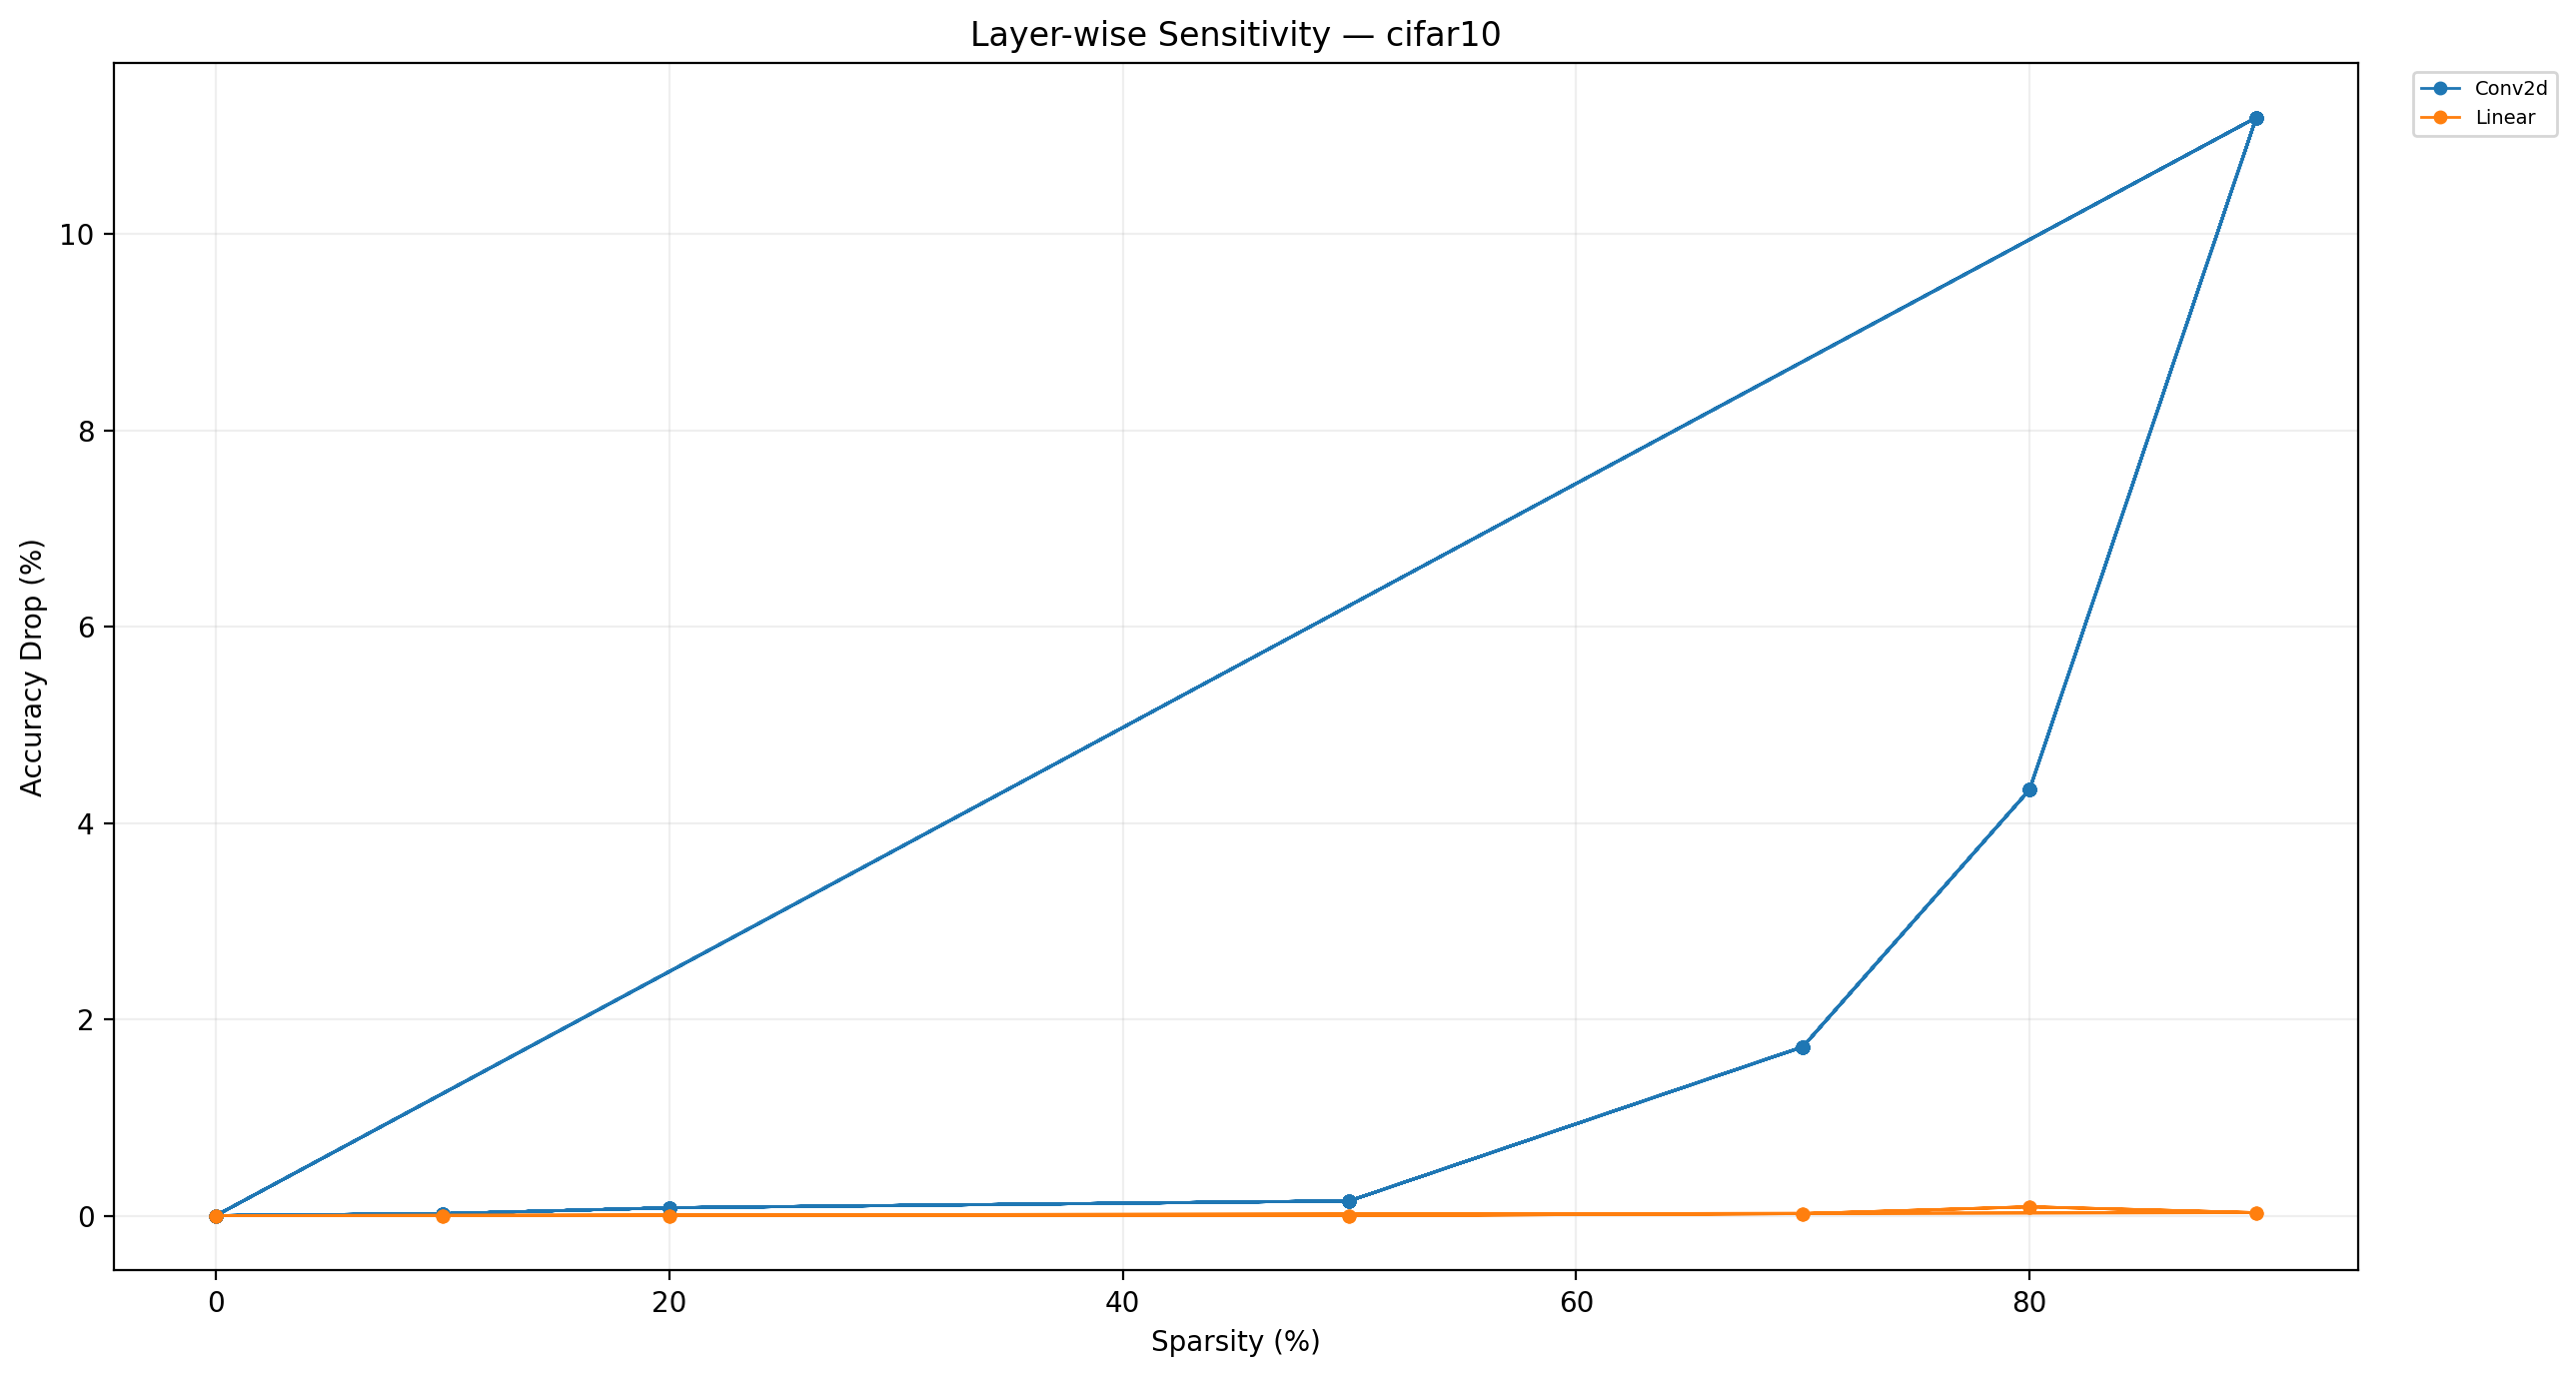

Saved: plots\sensitivity_cifar10.png


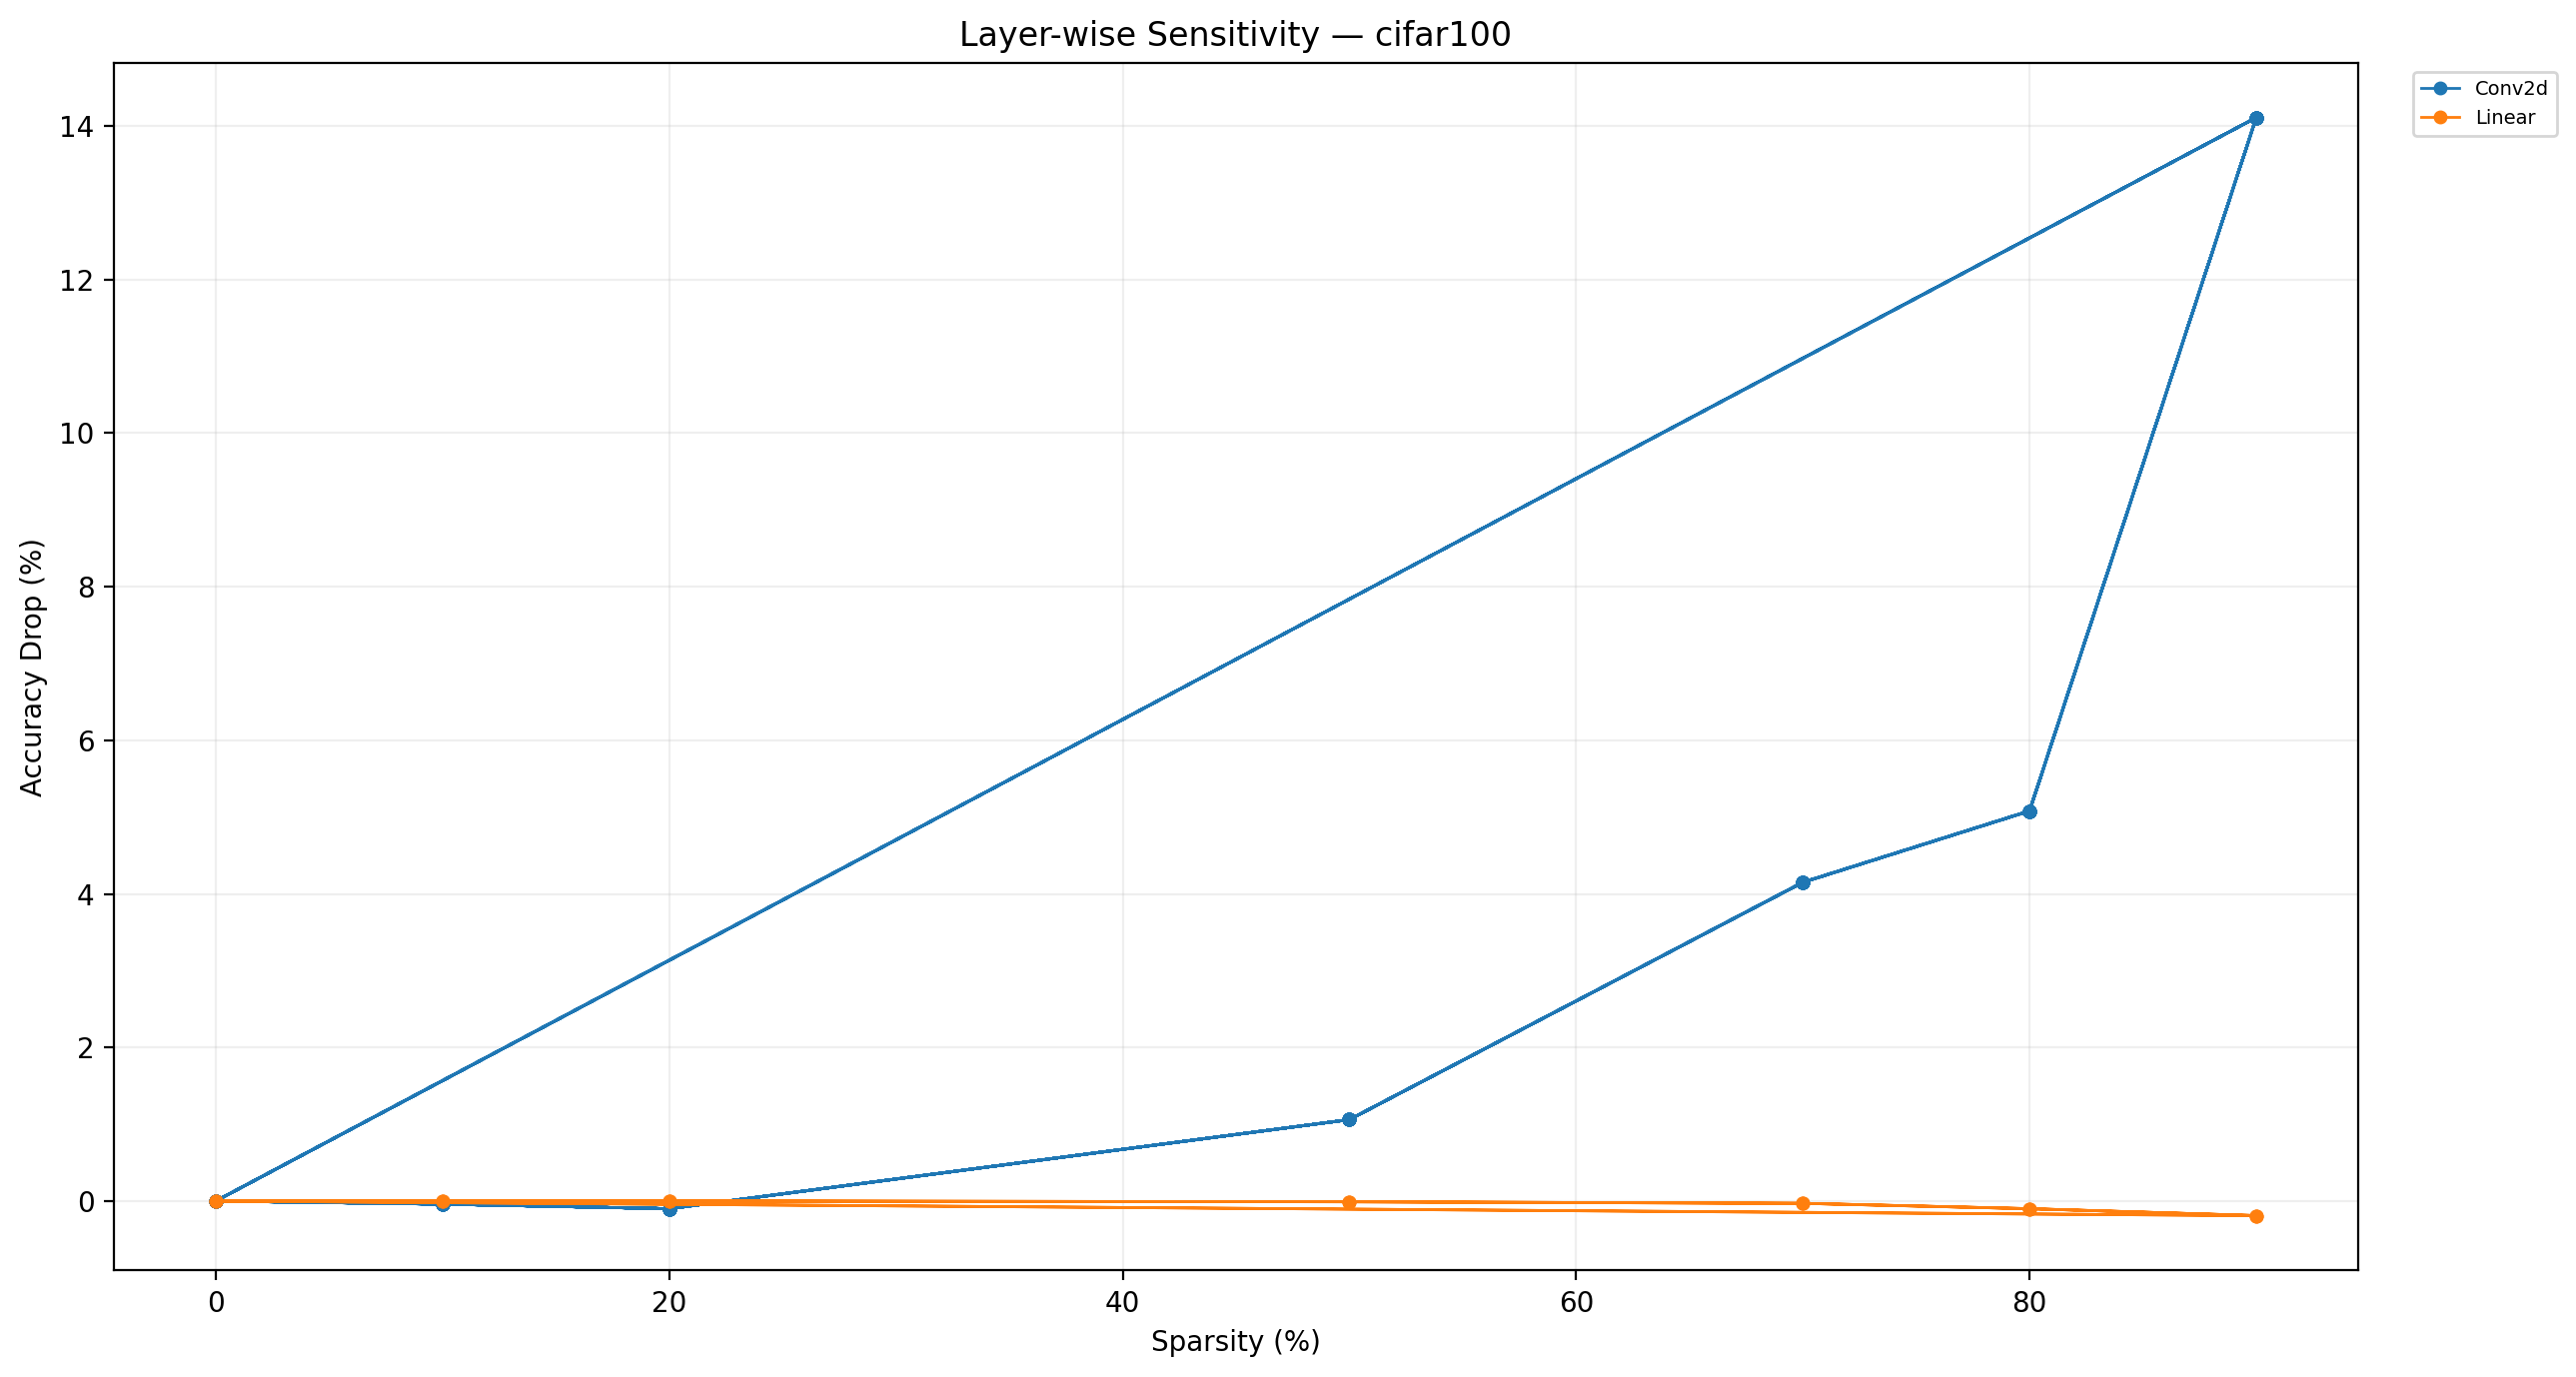

Saved: plots\sensitivity_cifar100.png


'plots\\sensitivity_cifar100.png'

In [15]:
import os

def plot_sensitivity_curves(dataset_name, csv_path=None, save_dir="plots", plot_drop=True):
    if csv_path is None:
        csv_path = f"results/sensitivity_layerwise_{dataset_name}.csv"
    df = pd.read_csv(csv_path)
    os.makedirs(save_dir, exist_ok=True)

    plt.figure(figsize=(12, 7))
    for layer, group in df.groupby("layer"):
        x = group["sparsity_pct"]
        y = group["top1_drop"] if plot_drop else group["top1"]
        plt.plot(x, y, marker="o", linewidth=1, markersize=4, label=layer)

    plt.xlabel("Sparsity (%)")
    plt.ylabel("Accuracy Drop (%)" if plot_drop else "Top-1 Accuracy (%)")
    plt.title(f"Layer-wise Sensitivity — {dataset_name}")
    plt.grid(alpha=0.2)
    plt.tight_layout()
    # place legend outside to avoid overlapping
    plt.legend(fontsize=7, bbox_to_anchor=(1.02, 1), loc="upper left", ncol=1)
    out_path = os.path.join(save_dir, f"sensitivity_{dataset_name}.png")
    plt.savefig(out_path, dpi=200, bbox_inches="tight")
    plt.close()
    display(Image(out_path))
    print(f"Saved: {out_path}")
    return out_path

# Example usage (run after sensitivity CSV exists)
plot_sensitivity_curves("cifar10")
plot_sensitivity_curves("cifar100")


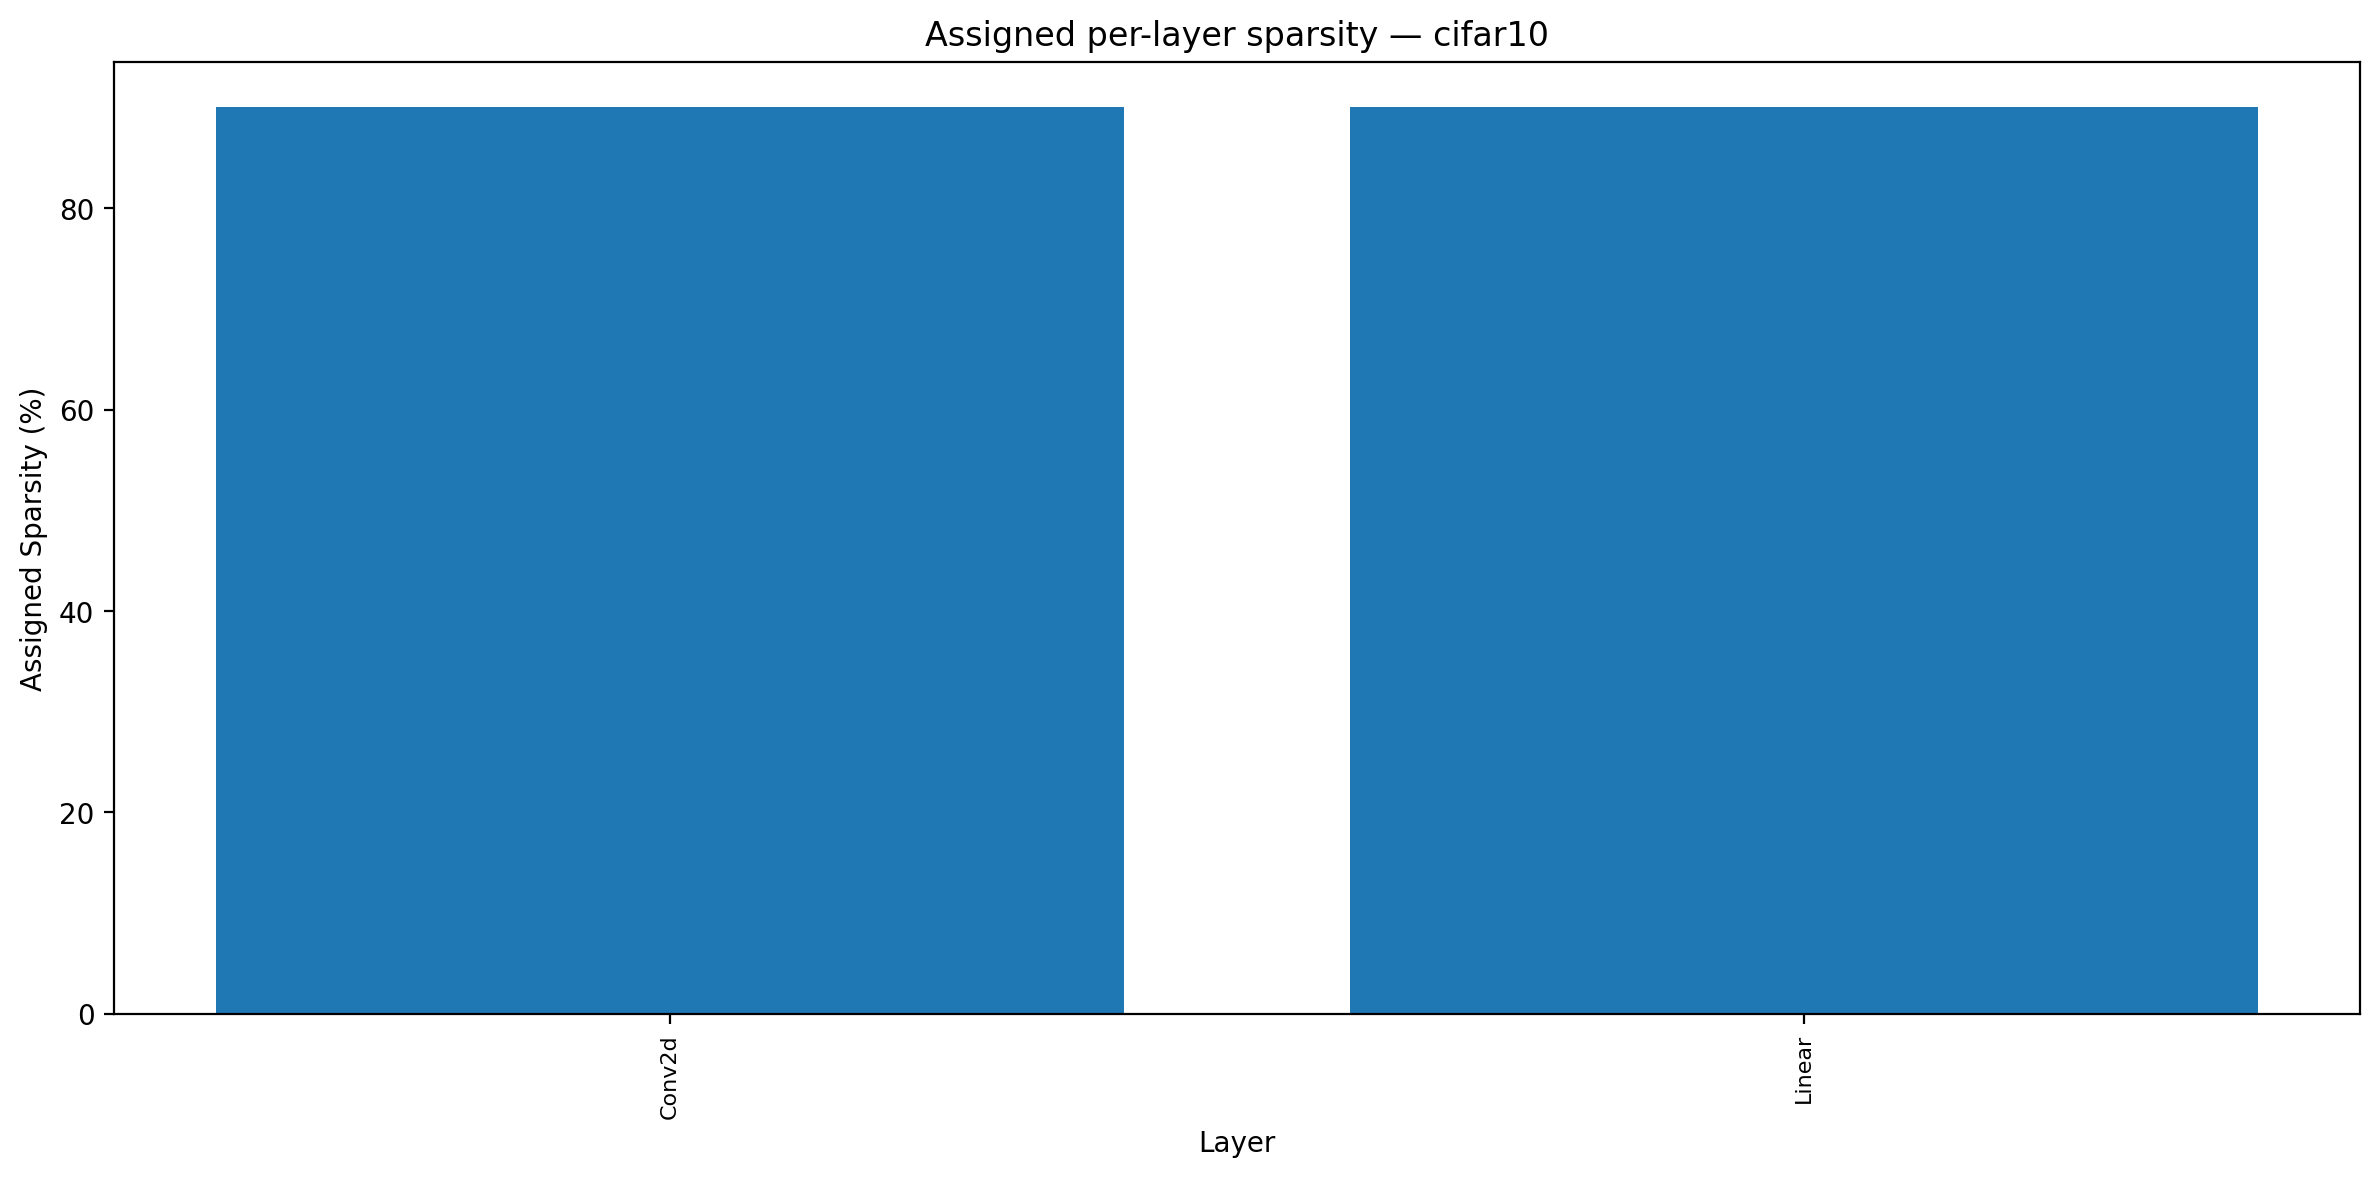

Saved: plots\sparsity_plan_cifar10.png
Weighted overall sparsity (from plan): 90.00%


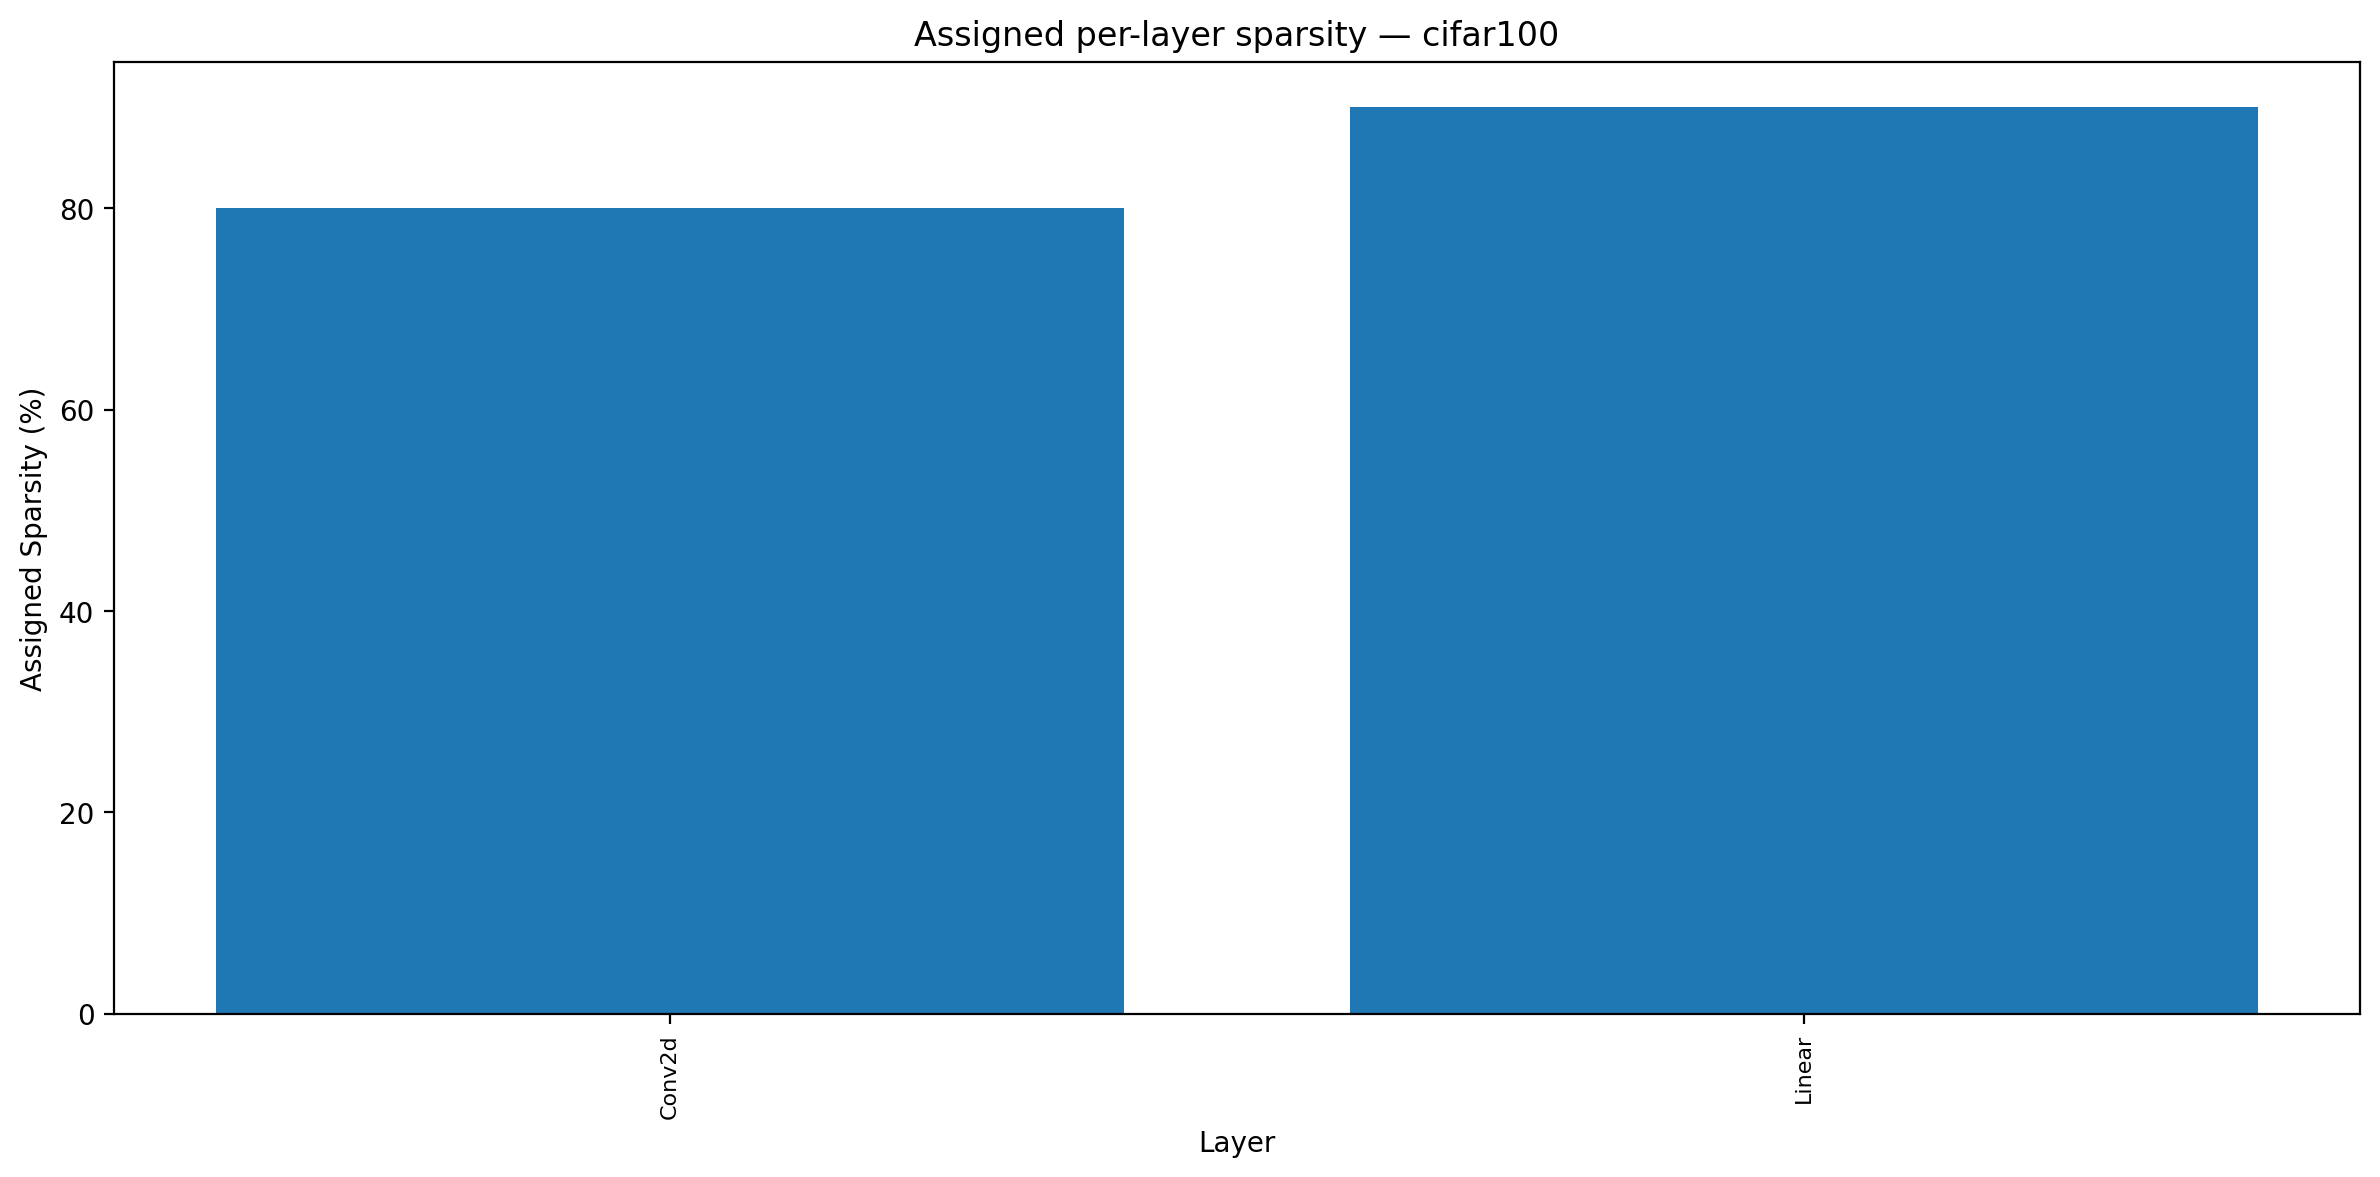

Saved: plots\sparsity_plan_cifar100.png
Weighted overall sparsity (from plan): 80.38%


('plots\\sparsity_plan_cifar100.png', np.float64(0.8037648162181851))

In [16]:
# Cell: Plot assigned per-layer sparsity (bar chart) + computed overall sparsity
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from IPython.display import Image, display

def plot_sparsity_plan(dataset_name, plan_csv=None, model=None, save_dir="plots"):
    if plan_csv is None:
        plan_csv = f"plans/sparsity_plan_{dataset_name}.csv"
    plan = pd.read_csv(plan_csv)
    os.makedirs(save_dir, exist_ok=True)

    # Sort by params descending for nicer bars
    plan_sorted = plan.sort_values("params", ascending=False).reset_index(drop=True)
    plt.figure(figsize=(12,6))
    plt.bar(np.arange(len(plan_sorted)), plan_sorted["assigned_sparsity"])
    plt.xticks(np.arange(len(plan_sorted)), plan_sorted["layer"], rotation=90, fontsize=8)
    plt.xlabel("Layer")
    plt.ylabel("Assigned Sparsity (%)")
    plt.title(f"Assigned per-layer sparsity — {dataset_name}")
    plt.tight_layout()
    out_path = os.path.join(save_dir, f"sparsity_plan_{dataset_name}.png")
    plt.savefig(out_path, dpi=200, bbox_inches="tight")
    plt.close()
    display(Image(out_path))
    print(f"Saved: {out_path}")

    # compute weighted overall sparsity (sanity-check)
    total_params = plan_sorted["params"].sum()
    weighted = (plan_sorted["params"] * plan_sorted["assigned_sparsity"] / 100.0).sum()
    overall = weighted / total_params
    print(f"Weighted overall sparsity (from plan): {overall*100:.2f}%")
    return out_path, overall

# Example usage
plot_sparsity_plan("cifar10")
plot_sparsity_plan("cifar100")


C:\Users\Fatim_Sproj\AppData\Local\Temp\ipykernel_33588\3249488918.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  masks = torch.load(mask_path)


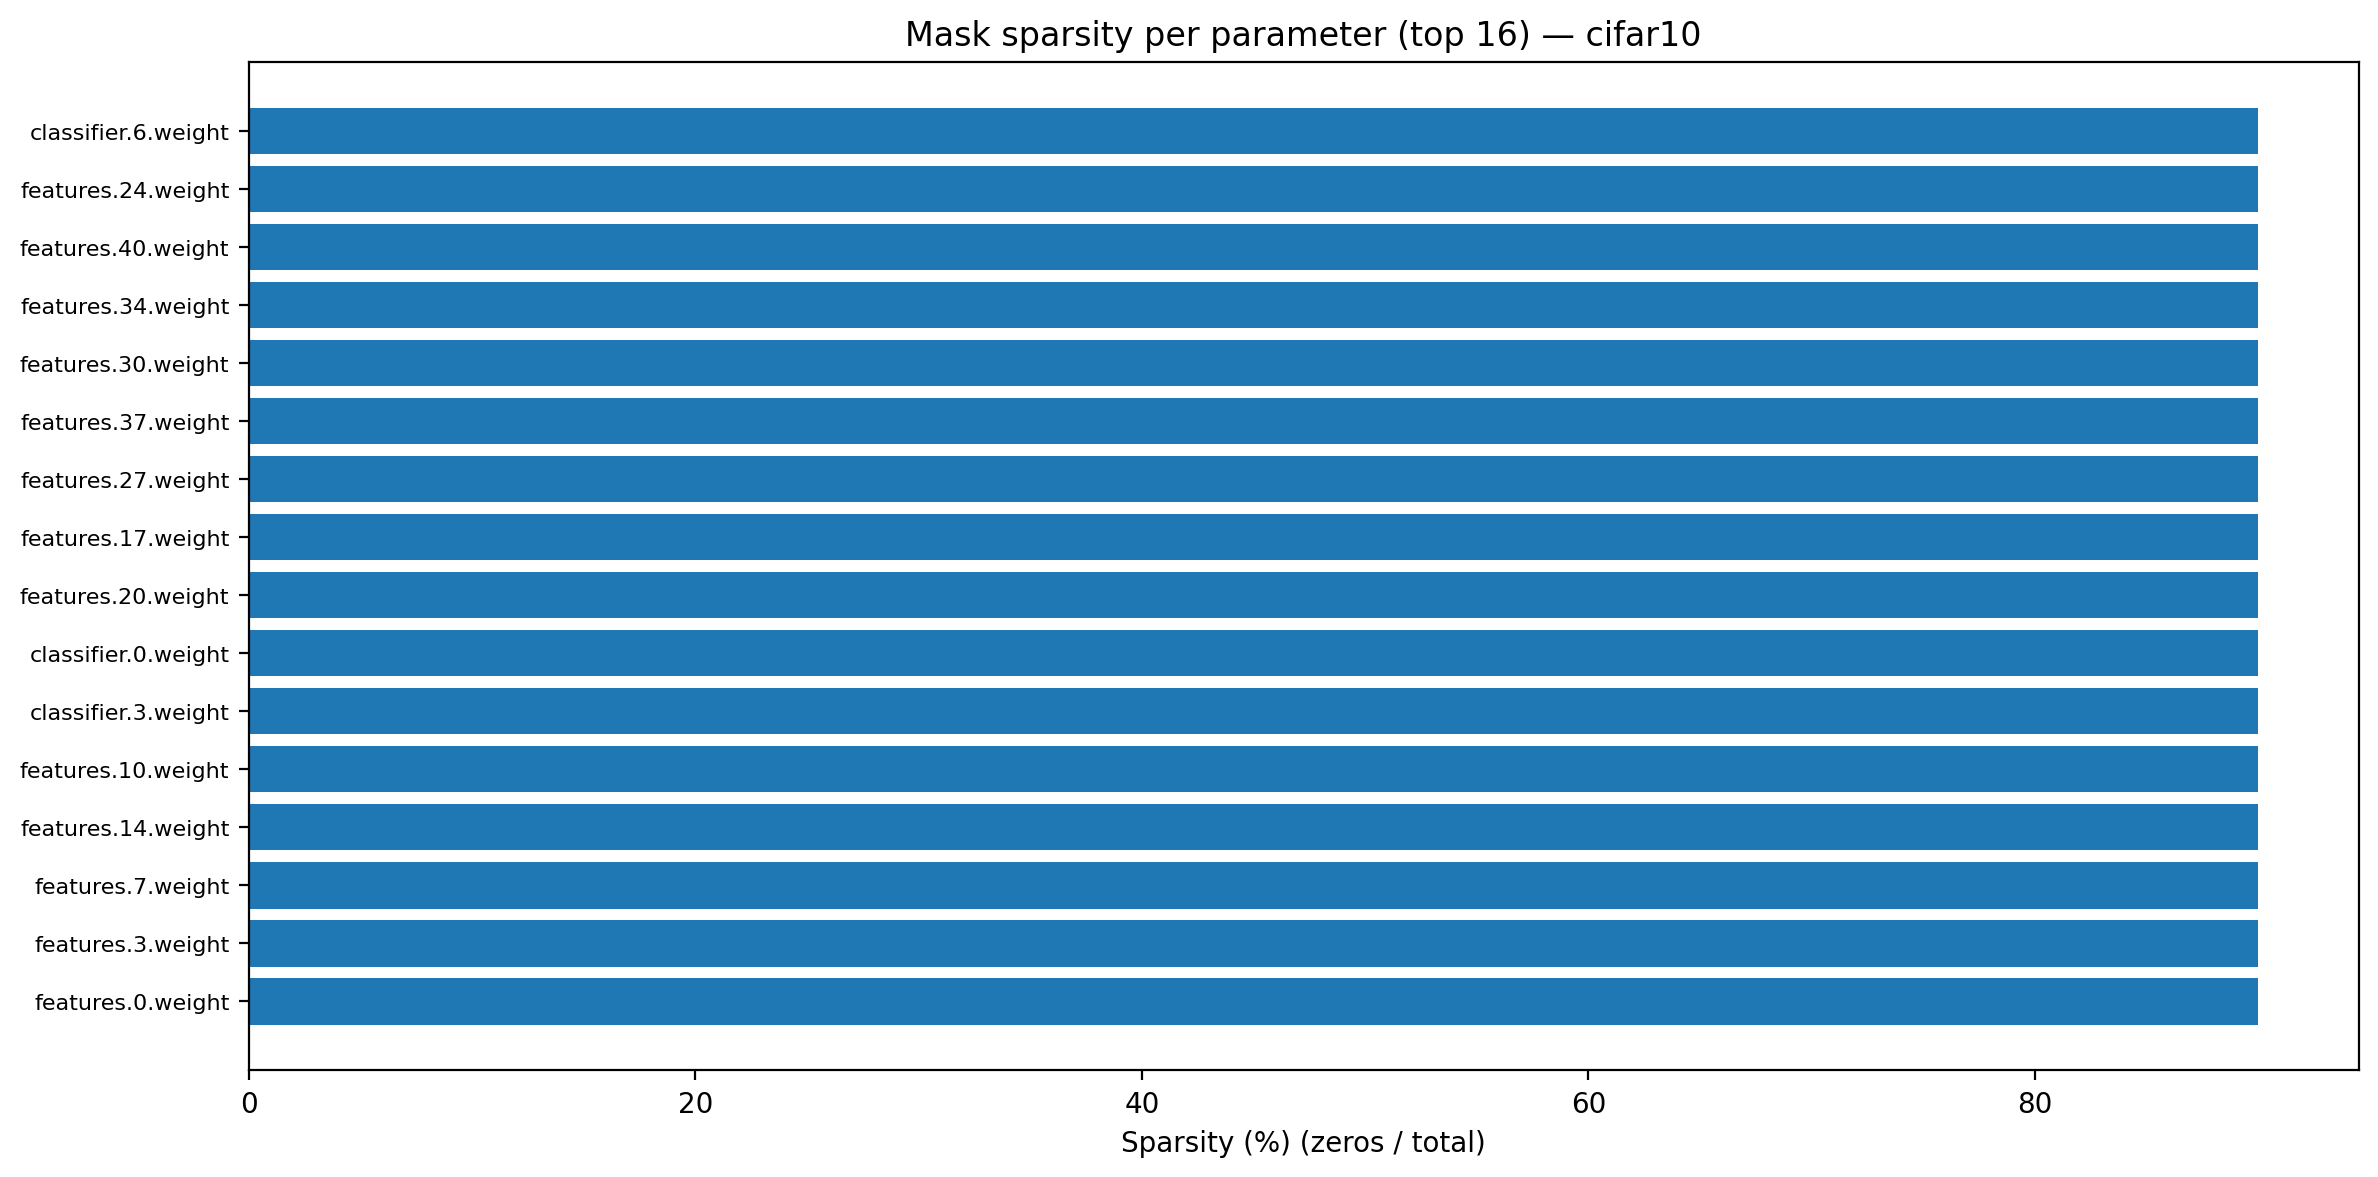

Saved: plots\mask_sparsity_cifar10.png


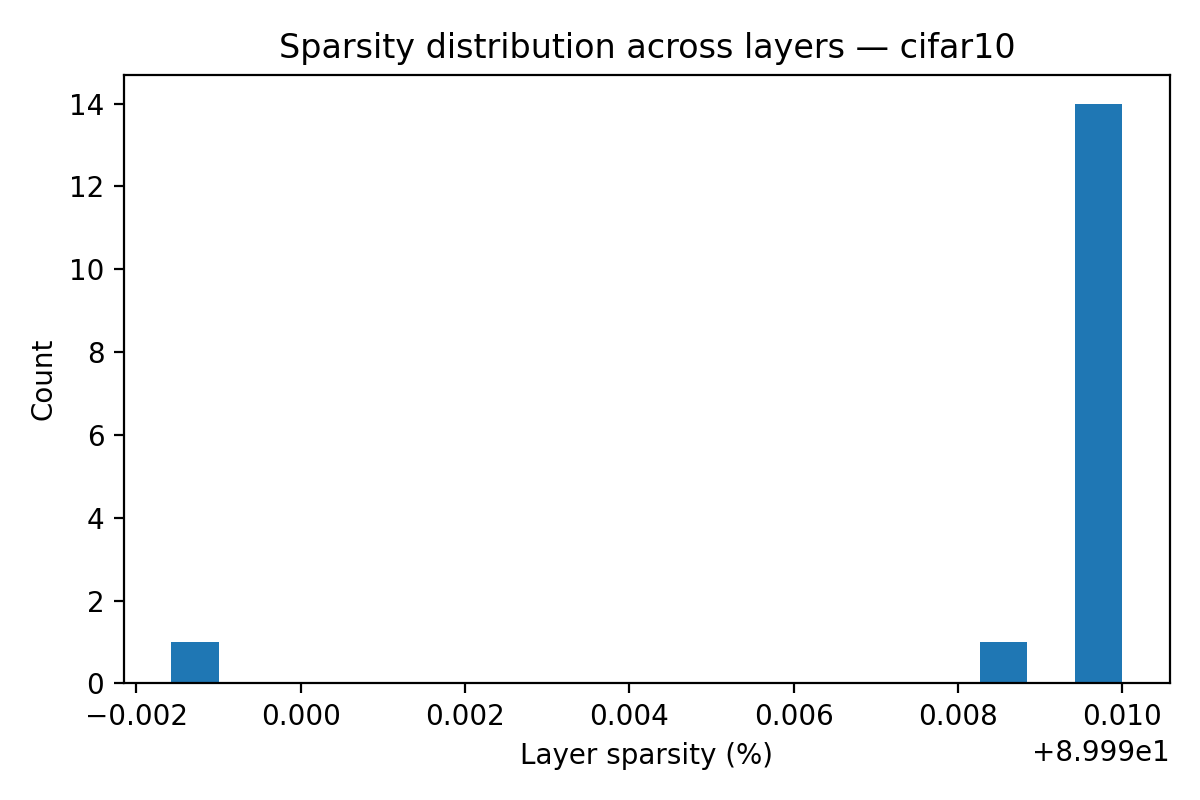

Saved: plots\mask_sparsity_hist_cifar10.png


C:\Users\Fatim_Sproj\AppData\Local\Temp\ipykernel_33588\3249488918.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  masks = torch.load(mask_path)


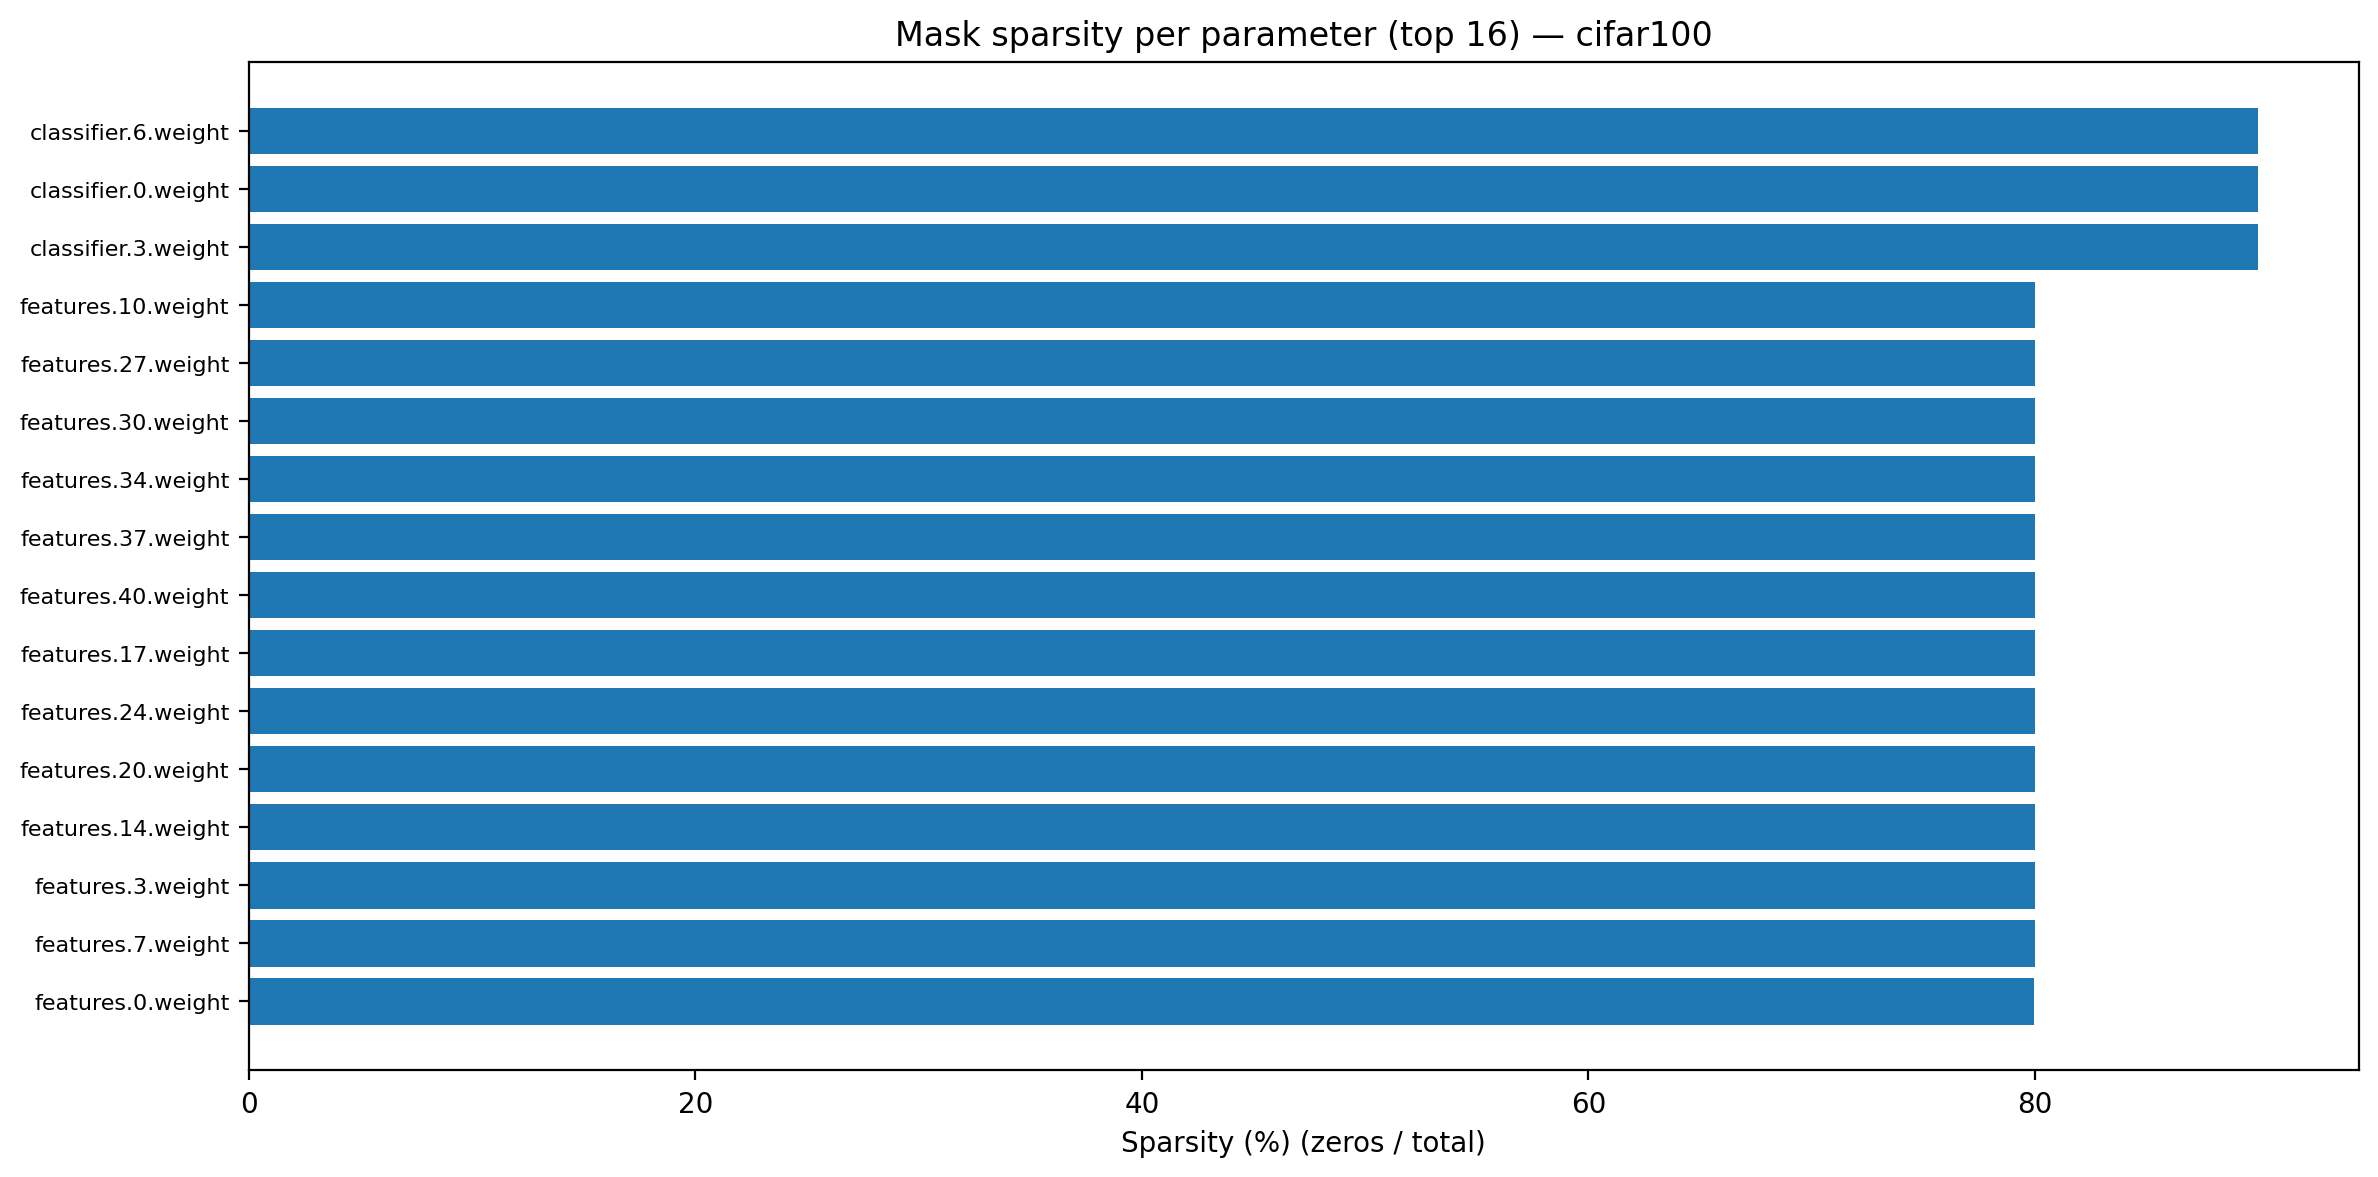

Saved: plots\mask_sparsity_cifar100.png


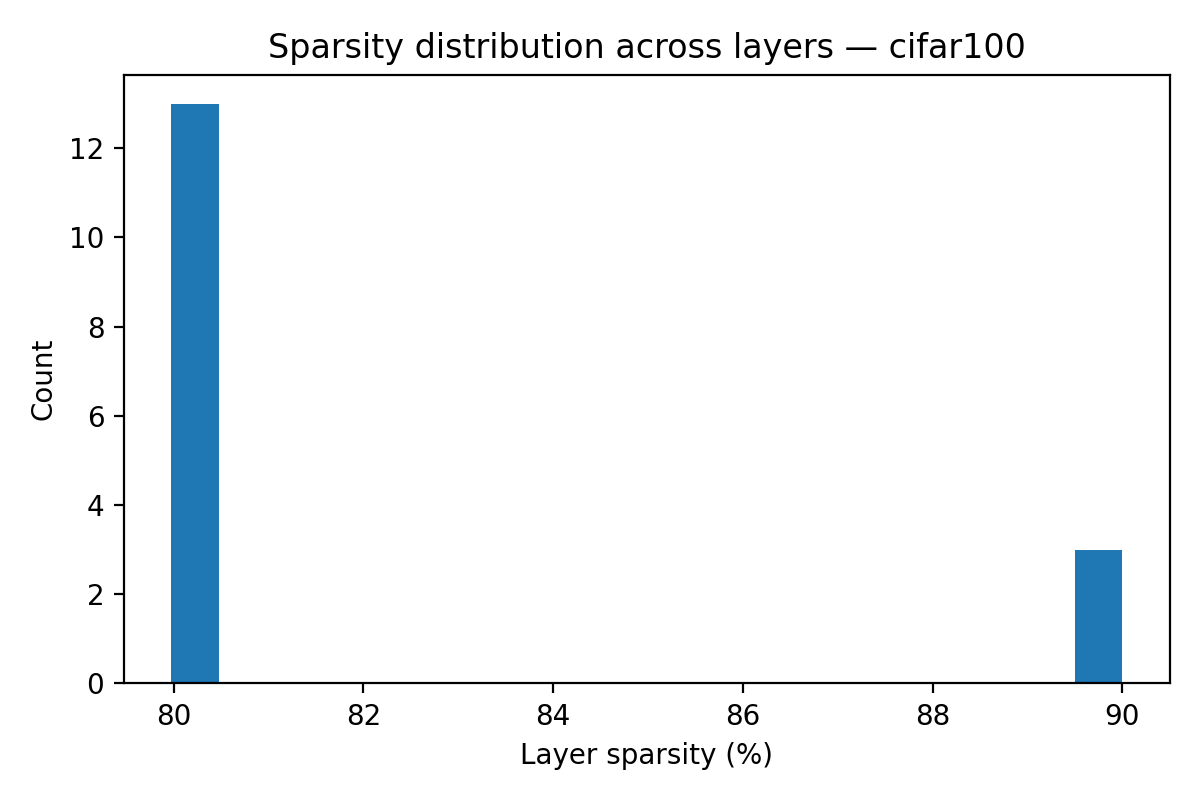

Saved: plots\mask_sparsity_hist_cifar100.png


In [17]:
# Cell: Visualize actual mask sparsity per parameter (post-pruning) and histogram
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from IPython.display import Image, display

def plot_mask_sparsity(dataset_name, mask_path=None, save_dir="plots"):
    if mask_path is None:
        mask_path = f"results/pruning_masks/{dataset_name}_unstructured_mask.pt"
    masks = torch.load(mask_path)
    os.makedirs(save_dir, exist_ok=True)

    rows = []
    for name, mask in masks.items():
        total = mask.numel()
        zeros = (mask == 0).sum().item()
        pct = 100.0 * zeros / total
        rows.append((name, total, zeros, pct))
    df = pd.DataFrame(rows, columns=["name", "total_params", "num_zero", "sparsity_pct"])
    df_sorted = df.sort_values("sparsity_pct", ascending=False).reset_index(drop=True)

    # Bar plot: top 40 layers by sparsity (or all if small)
    topk = min(40, len(df_sorted))
    plt.figure(figsize=(12,6))
    plt.barh(np.arange(topk), df_sorted["sparsity_pct"].values[:topk])
    plt.yticks(np.arange(topk), df_sorted["name"].values[:topk], fontsize=8)
    plt.xlabel("Sparsity (%) (zeros / total)")
    plt.title(f"Mask sparsity per parameter (top {topk}) — {dataset_name}")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    out_path = os.path.join(save_dir, f"mask_sparsity_{dataset_name}.png")
    plt.savefig(out_path, dpi=200, bbox_inches="tight")
    plt.close()
    display(Image(out_path))
    print(f"Saved: {out_path}")

    # Histogram of sparsity across layers
    plt.figure(figsize=(6,4))
    plt.hist(df["sparsity_pct"], bins=20)
    plt.xlabel("Layer sparsity (%)")
    plt.ylabel("Count")
    plt.title(f"Sparsity distribution across layers — {dataset_name}")
    hist_path = os.path.join(save_dir, f"mask_sparsity_hist_{dataset_name}.png")
    plt.tight_layout()
    plt.savefig(hist_path, dpi=200)
    plt.close()
    display(Image(hist_path))
    print(f"Saved: {hist_path}")

    return df

# Example usage
df_mask10 = plot_mask_sparsity("cifar10")
df_mask100 = plot_mask_sparsity("cifar100")


C:\Users\Fatim_Sproj\AppData\Local\Temp\ipykernel_33588\3249488918.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  masks = torch.load(mask_path)


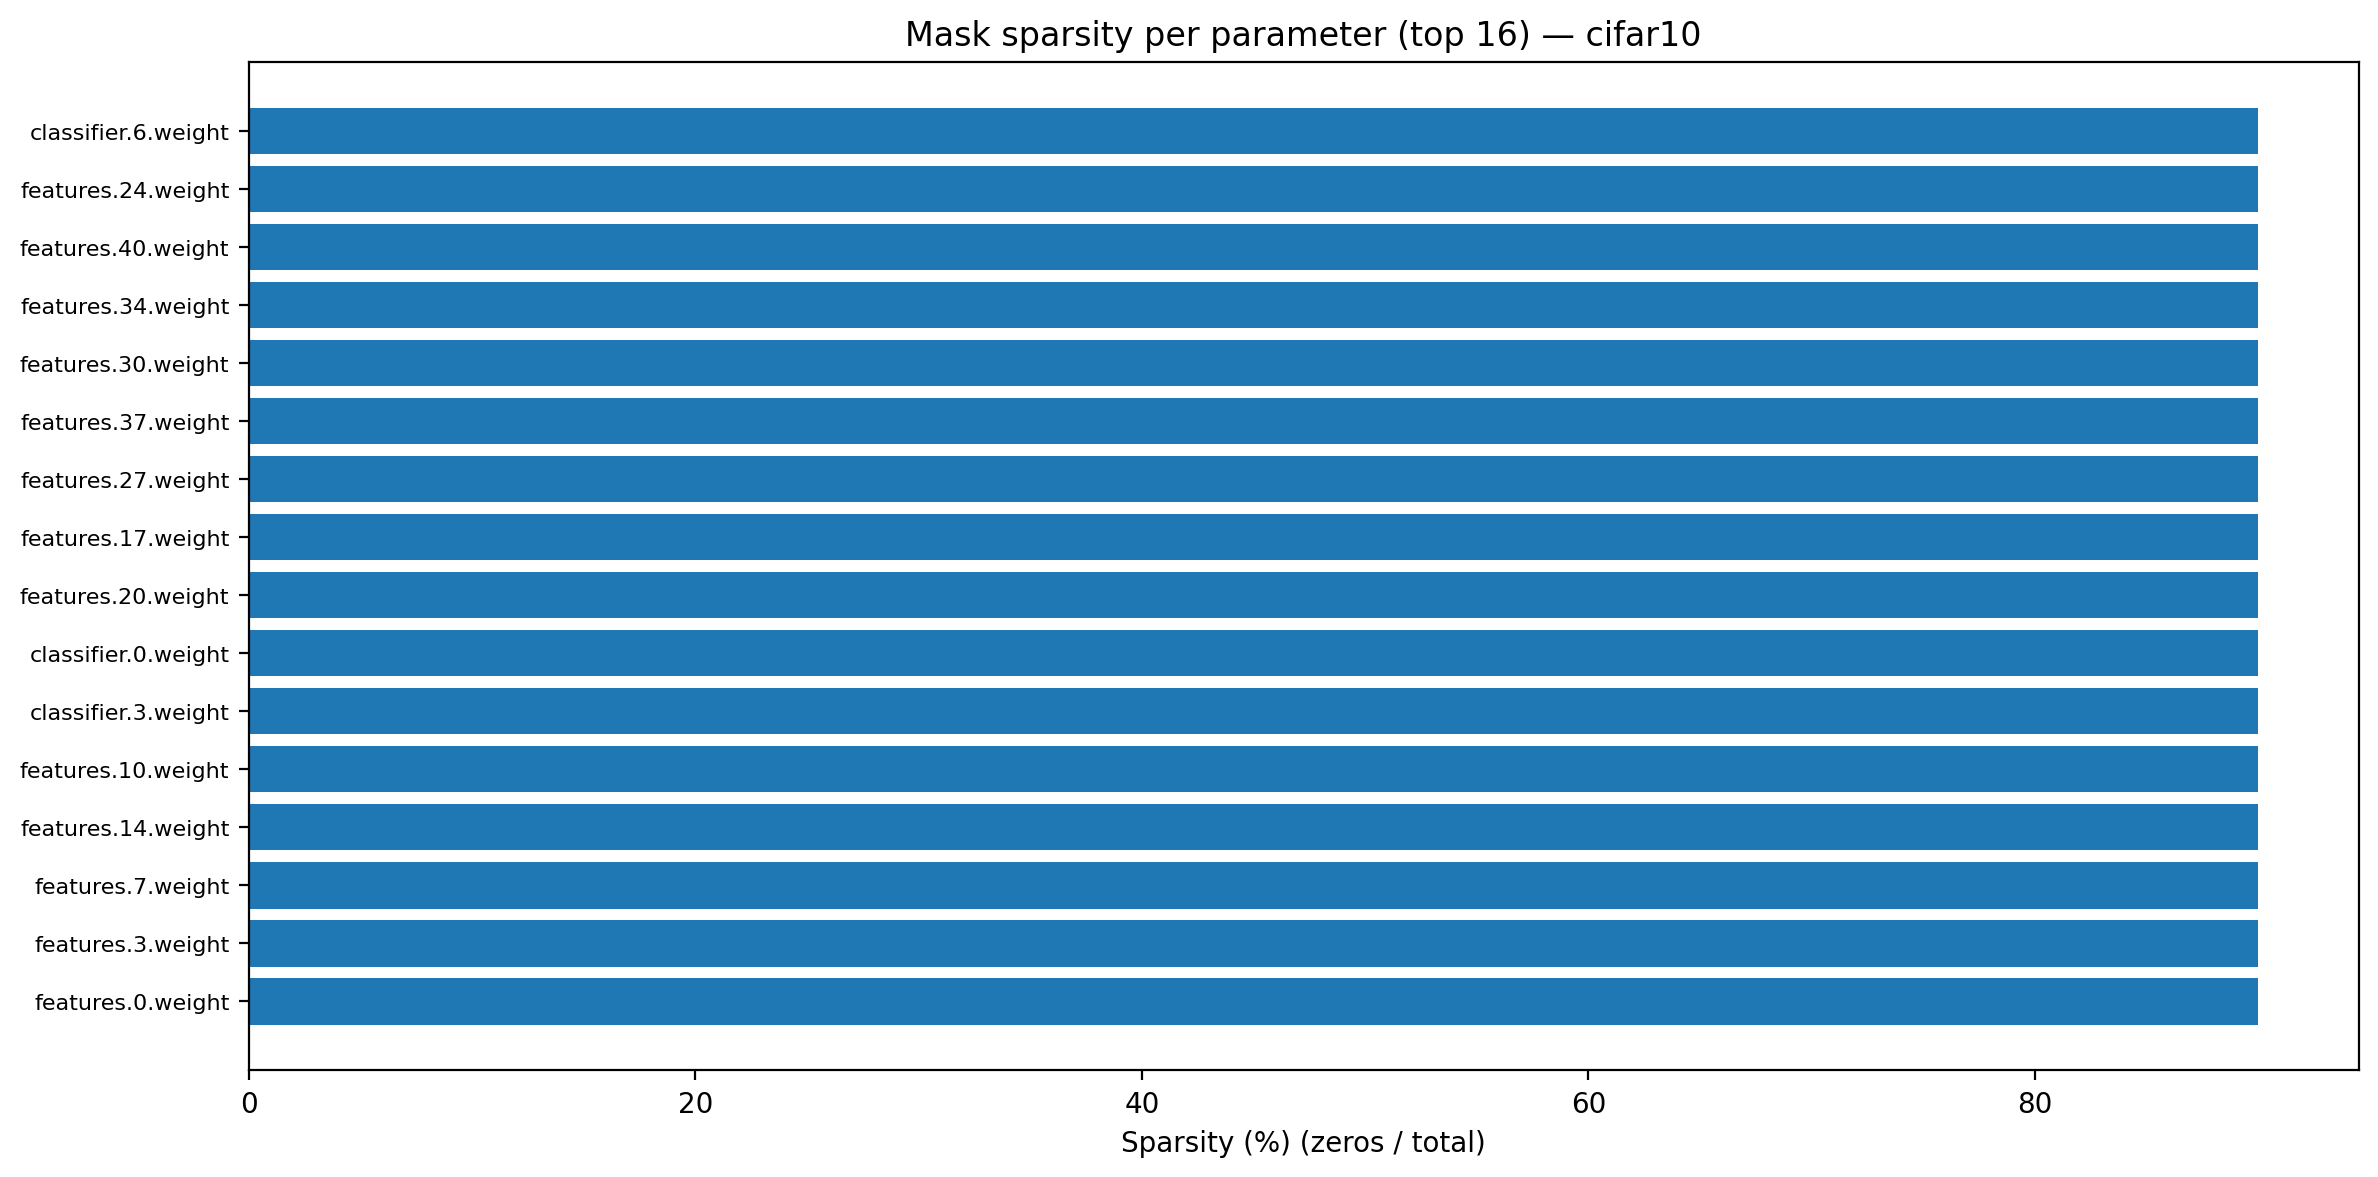

Saved: plots\mask_sparsity_cifar10.png


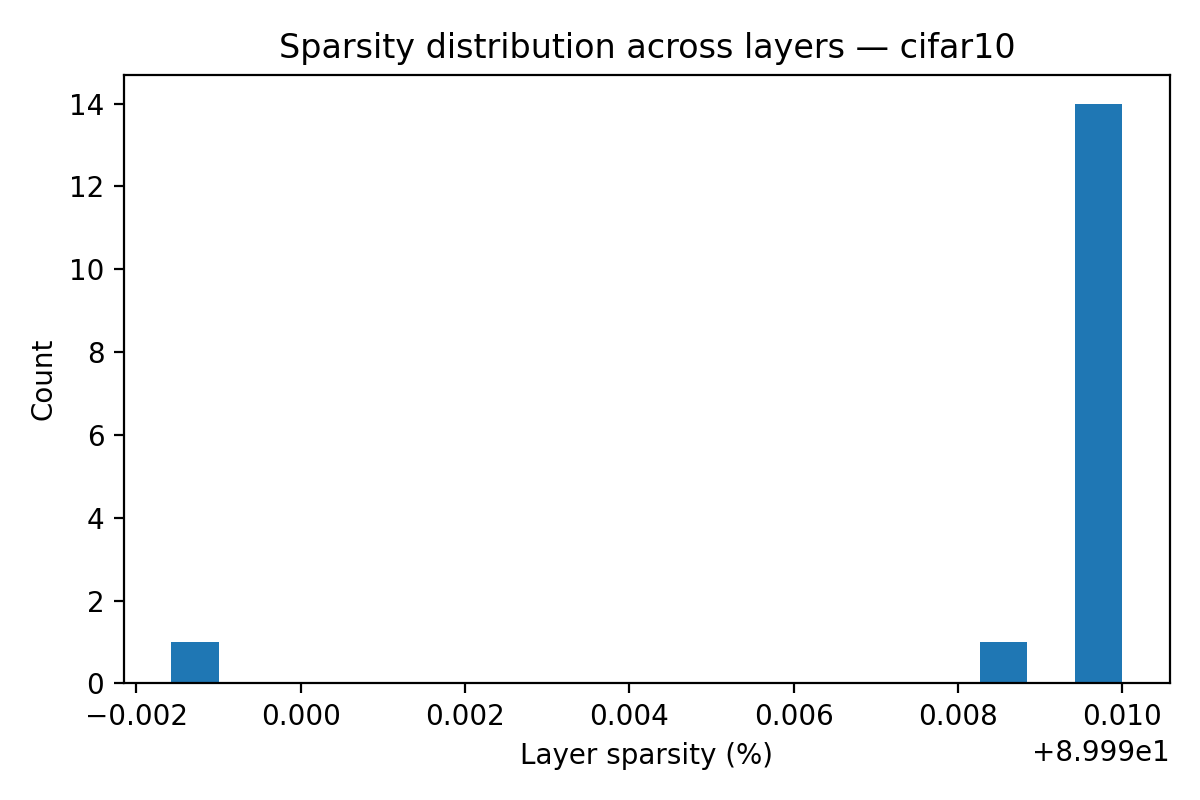

Saved: plots\mask_sparsity_hist_cifar10.png


C:\Users\Fatim_Sproj\AppData\Local\Temp\ipykernel_33588\3249488918.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  masks = torch.load(mask_path)


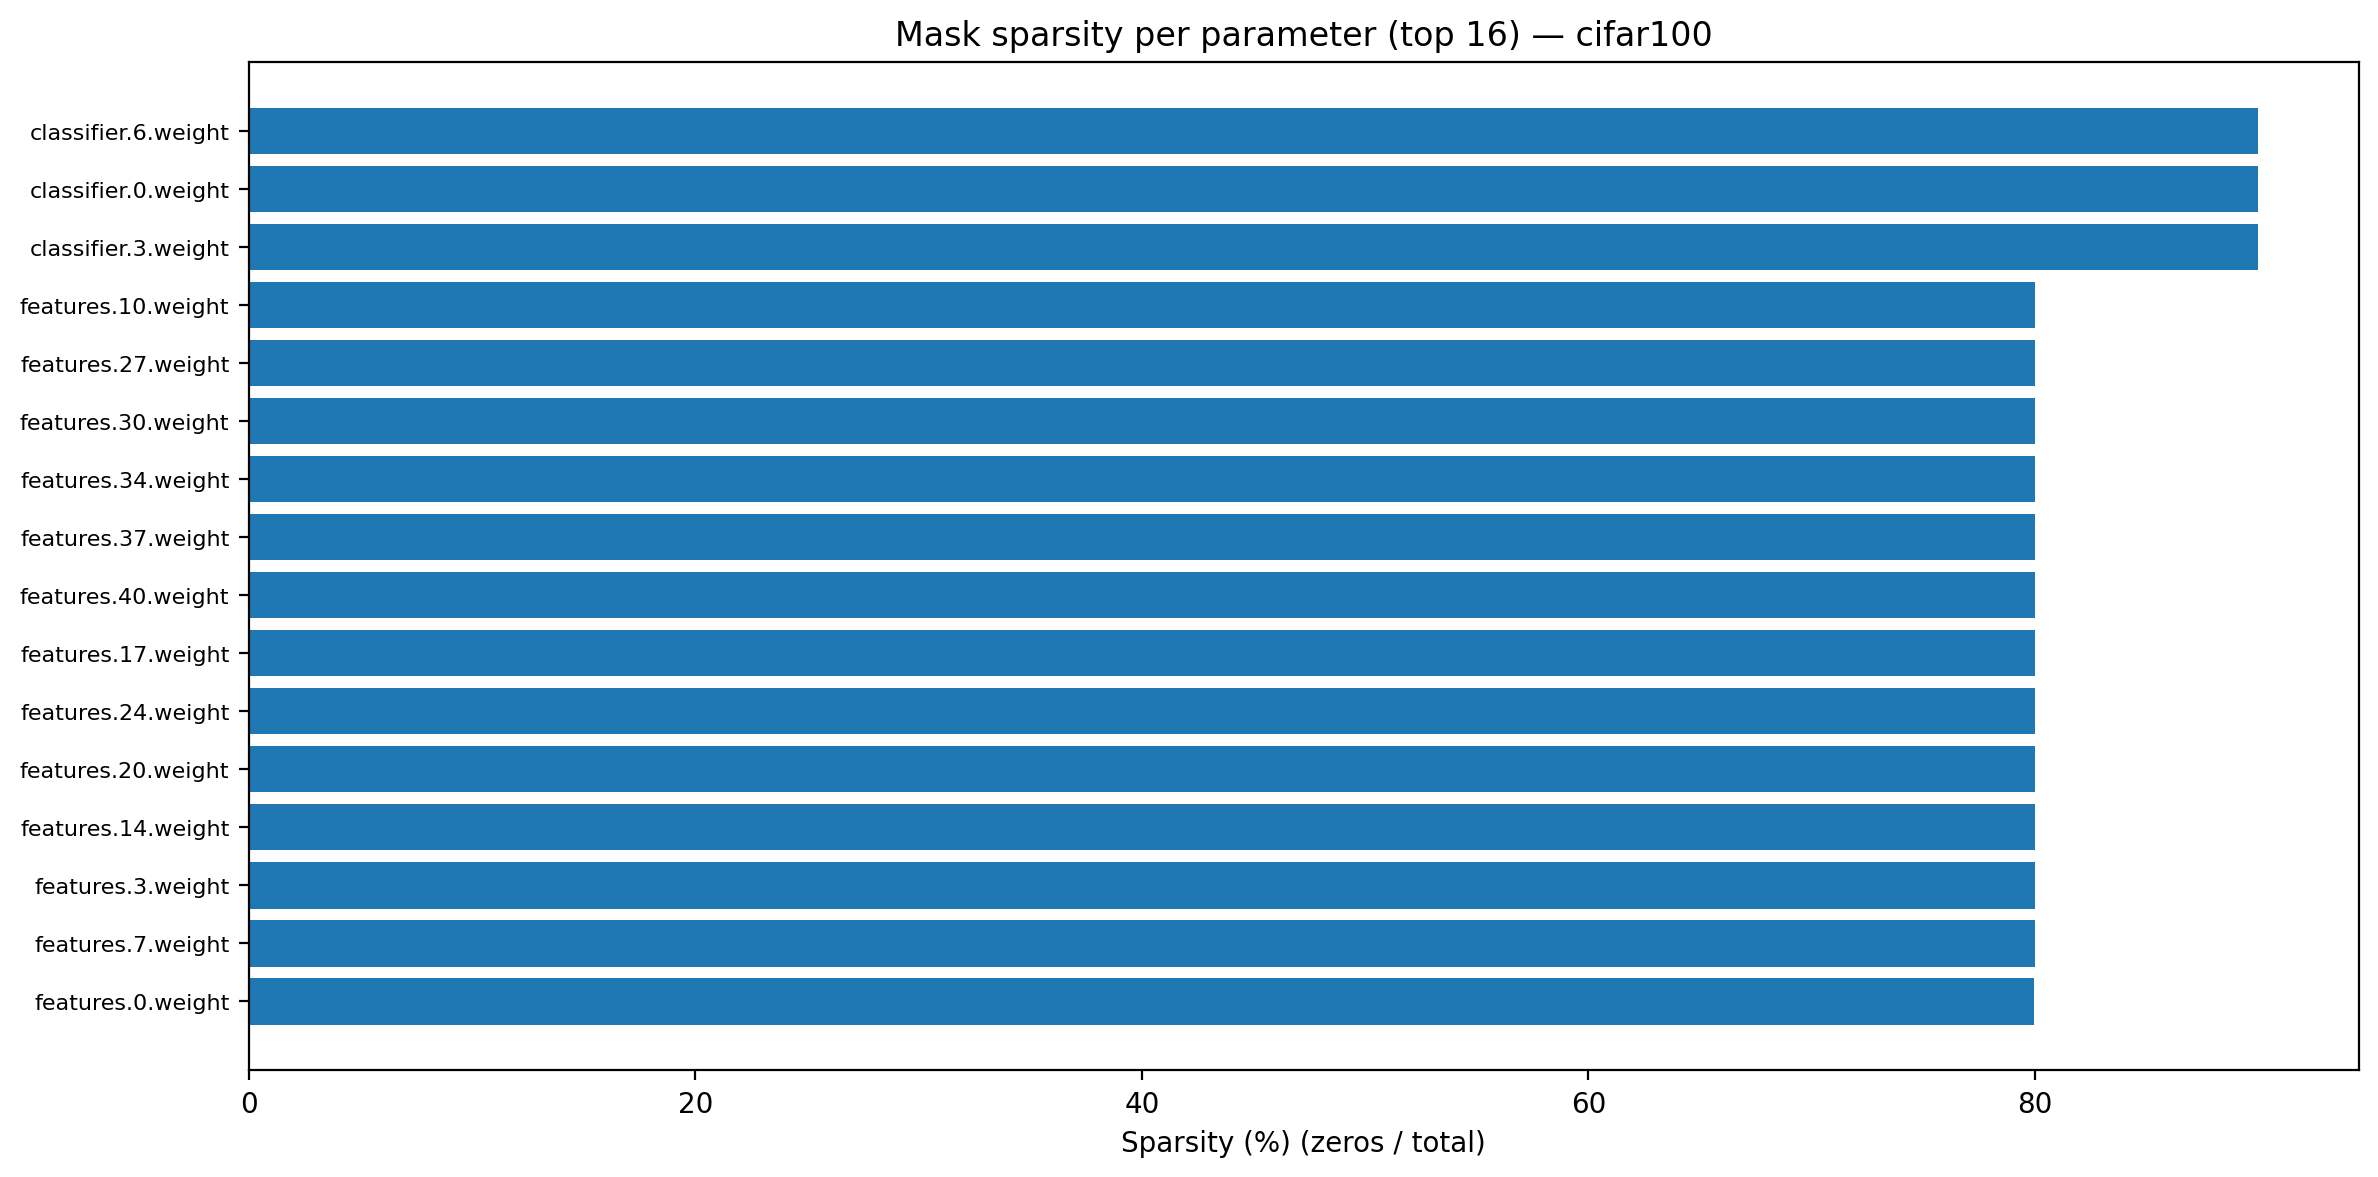

Saved: plots\mask_sparsity_cifar100.png


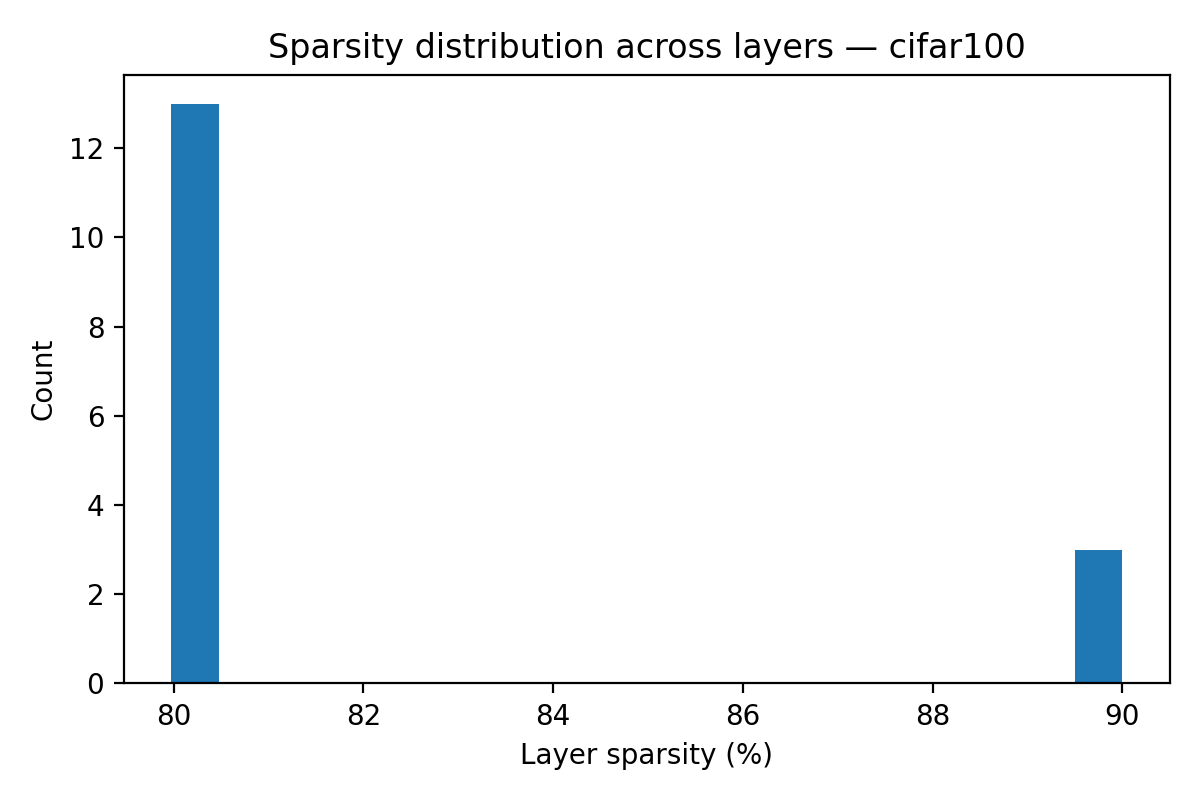

Saved: plots\mask_sparsity_hist_cifar100.png


In [18]:
# Cell: Visualize actual mask sparsity per parameter (post-pruning) and histogram
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from IPython.display import Image, display

def plot_mask_sparsity(dataset_name, mask_path=None, save_dir="plots"):
    if mask_path is None:
        mask_path = f"results/pruning_masks/{dataset_name}_unstructured_mask.pt"
    masks = torch.load(mask_path)
    os.makedirs(save_dir, exist_ok=True)

    rows = []
    for name, mask in masks.items():
        total = mask.numel()
        zeros = (mask == 0).sum().item()
        pct = 100.0 * zeros / total
        rows.append((name, total, zeros, pct))
    df = pd.DataFrame(rows, columns=["name", "total_params", "num_zero", "sparsity_pct"])
    df_sorted = df.sort_values("sparsity_pct", ascending=False).reset_index(drop=True)

    # Bar plot: top 40 layers by sparsity (or all if small)
    topk = min(40, len(df_sorted))
    plt.figure(figsize=(12,6))
    plt.barh(np.arange(topk), df_sorted["sparsity_pct"].values[:topk])
    plt.yticks(np.arange(topk), df_sorted["name"].values[:topk], fontsize=8)
    plt.xlabel("Sparsity (%) (zeros / total)")
    plt.title(f"Mask sparsity per parameter (top {topk}) — {dataset_name}")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    out_path = os.path.join(save_dir, f"mask_sparsity_{dataset_name}.png")
    plt.savefig(out_path, dpi=200, bbox_inches="tight")
    plt.close()
    display(Image(out_path))
    print(f"Saved: {out_path}")

    # Histogram of sparsity across layers
    plt.figure(figsize=(6,4))
    plt.hist(df["sparsity_pct"], bins=20)
    plt.xlabel("Layer sparsity (%)")
    plt.ylabel("Count")
    plt.title(f"Sparsity distribution across layers — {dataset_name}")
    hist_path = os.path.join(save_dir, f"mask_sparsity_hist_{dataset_name}.png")
    plt.tight_layout()
    plt.savefig(hist_path, dpi=200)
    plt.close()
    display(Image(hist_path))
    print(f"Saved: {hist_path}")

    return df

# Example usage
df_mask10 = plot_mask_sparsity("cifar10")
df_mask100 = plot_mask_sparsity("cifar100")


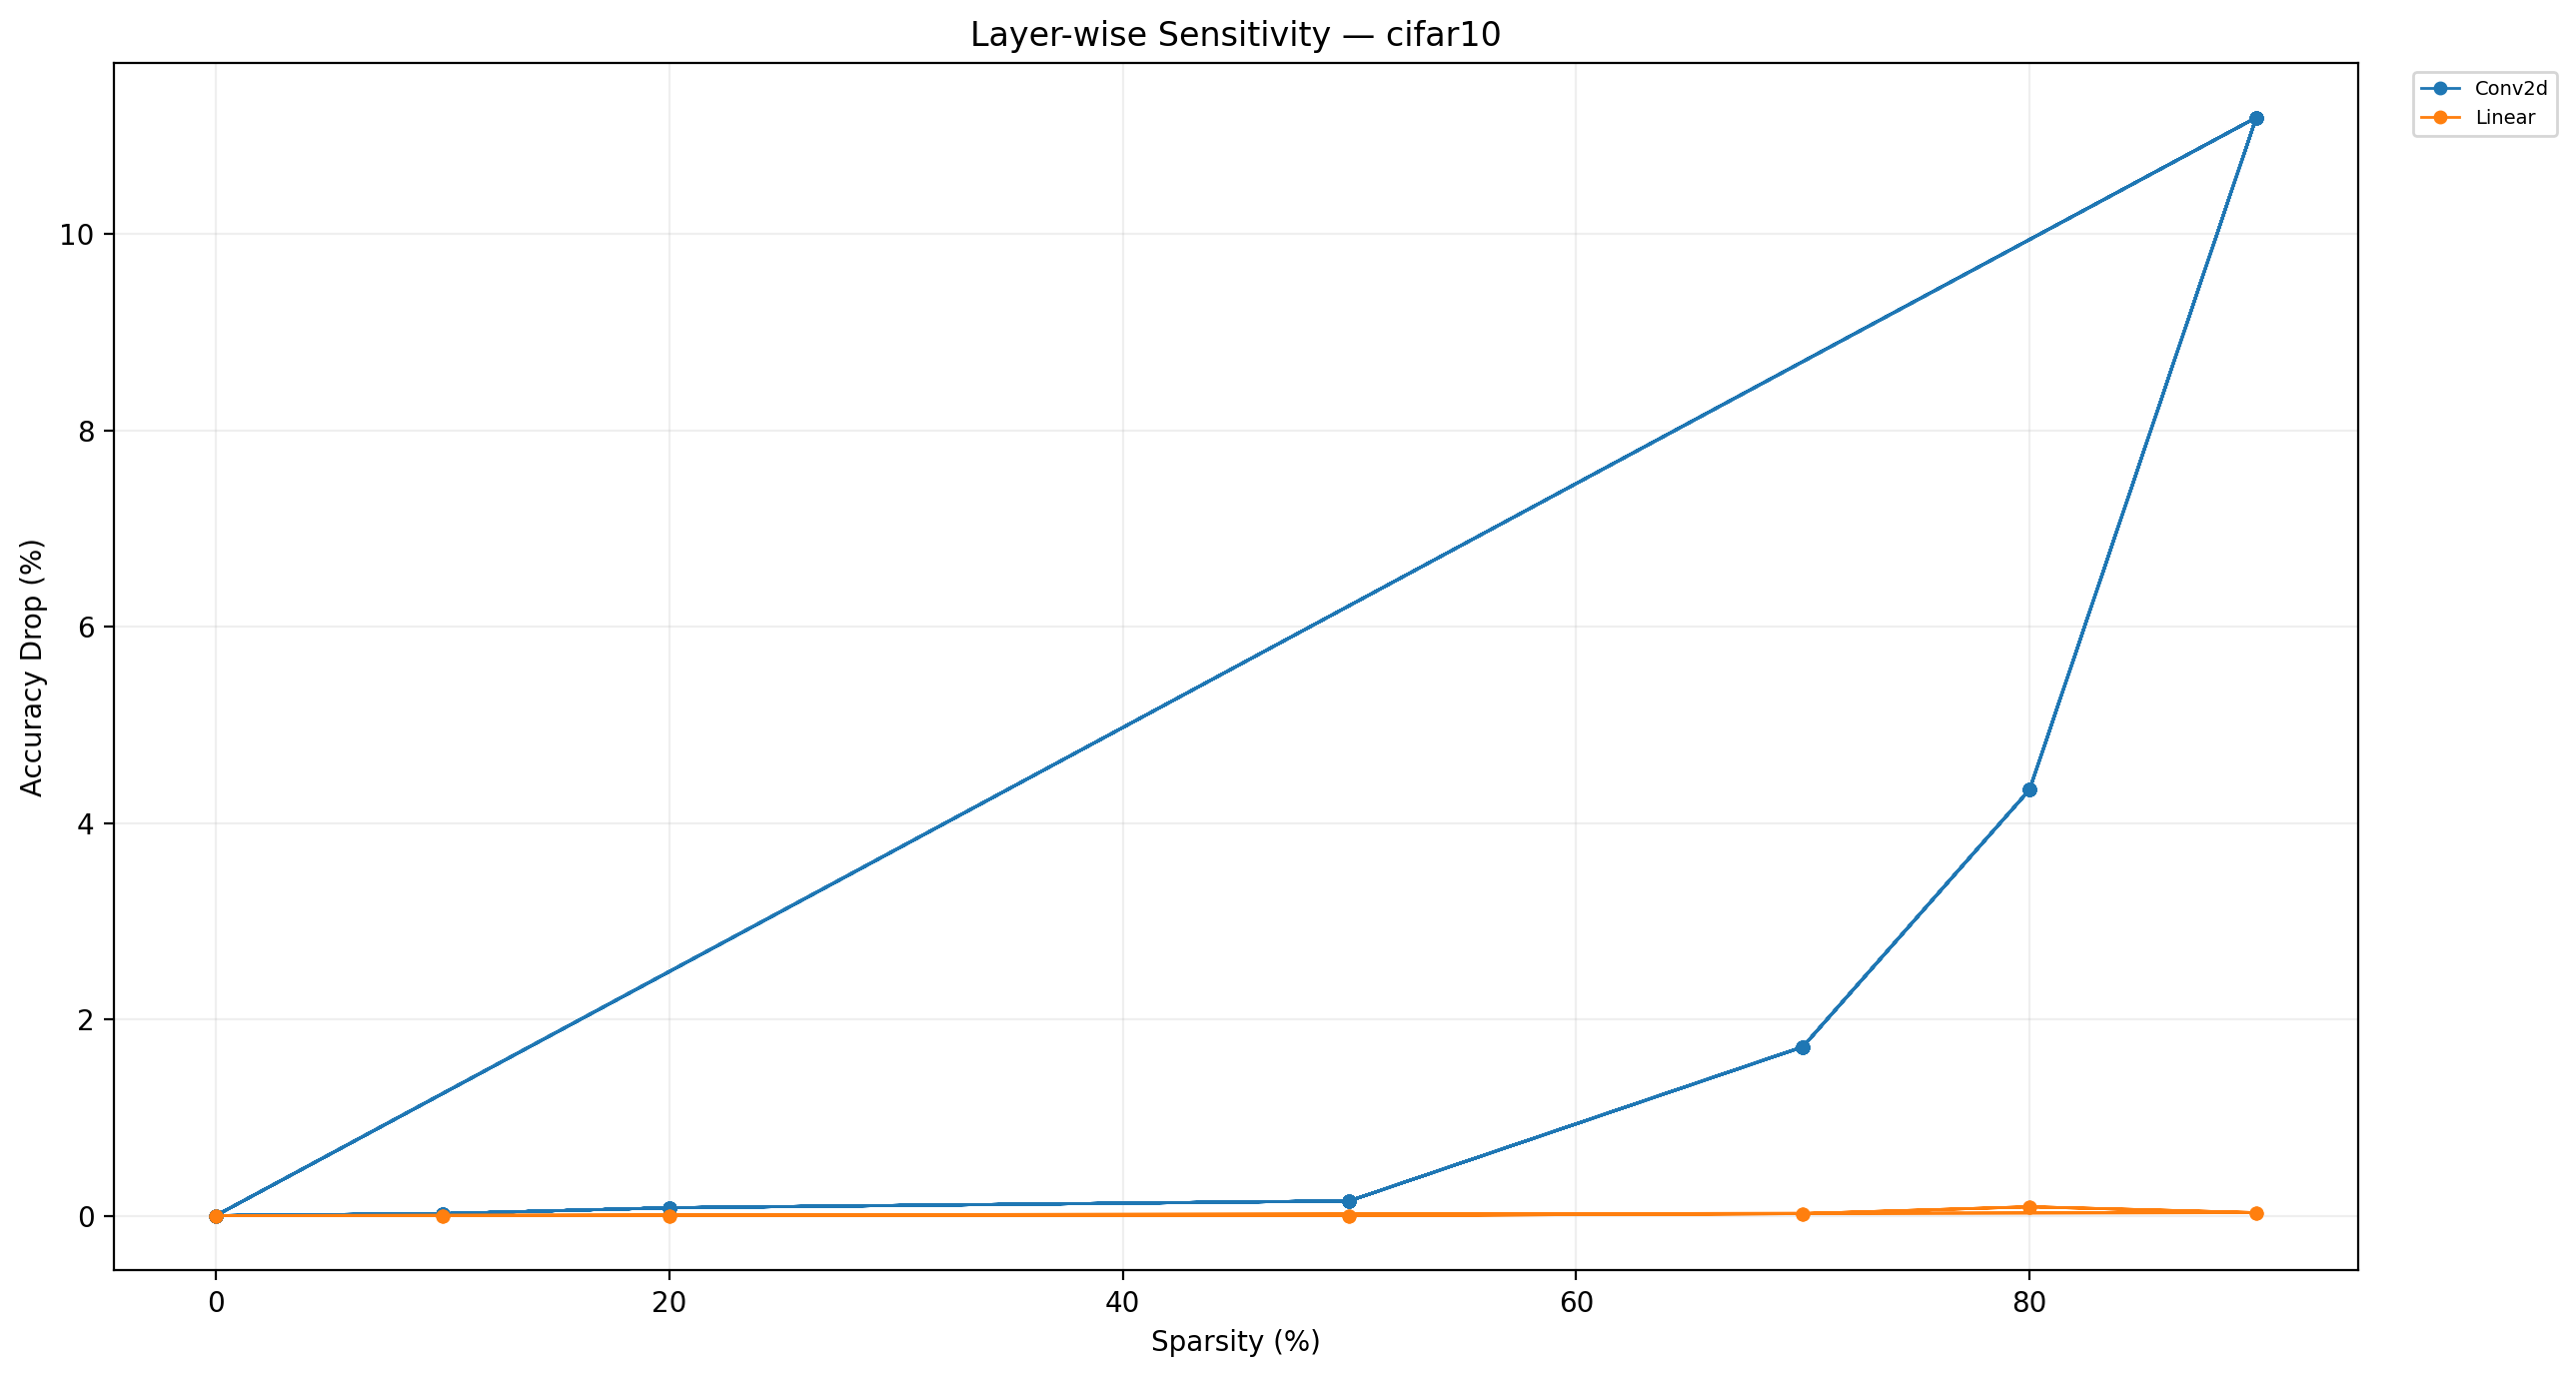

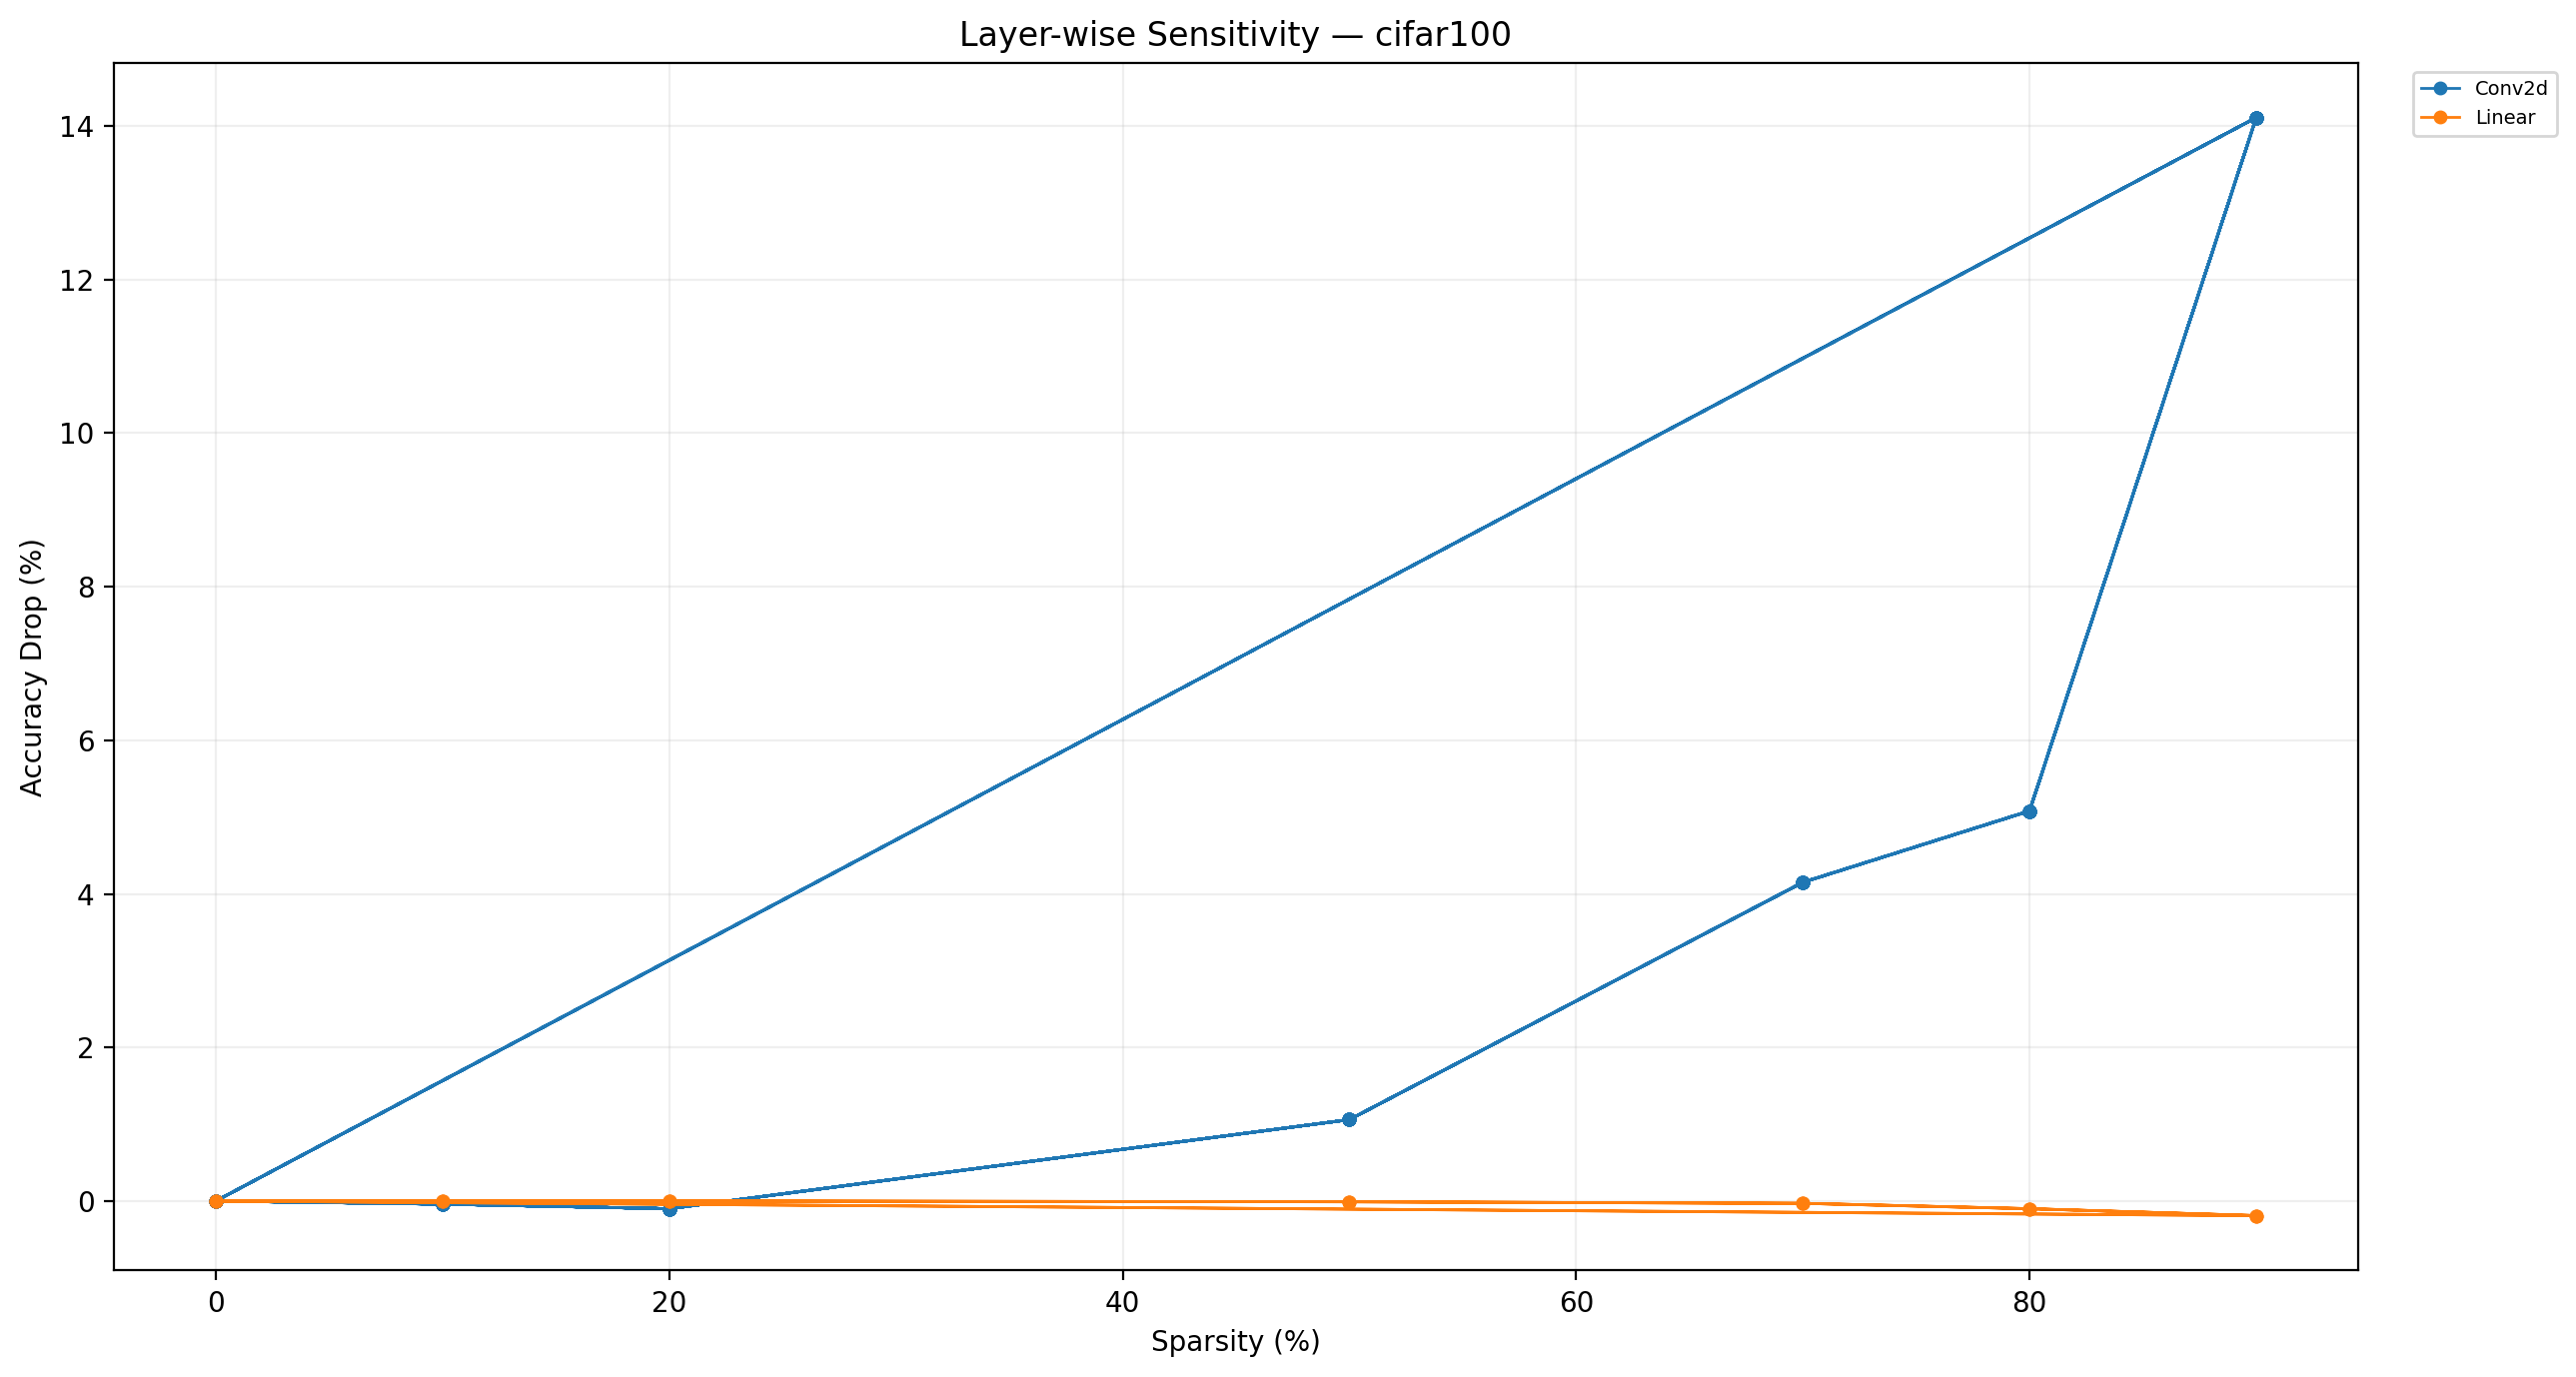

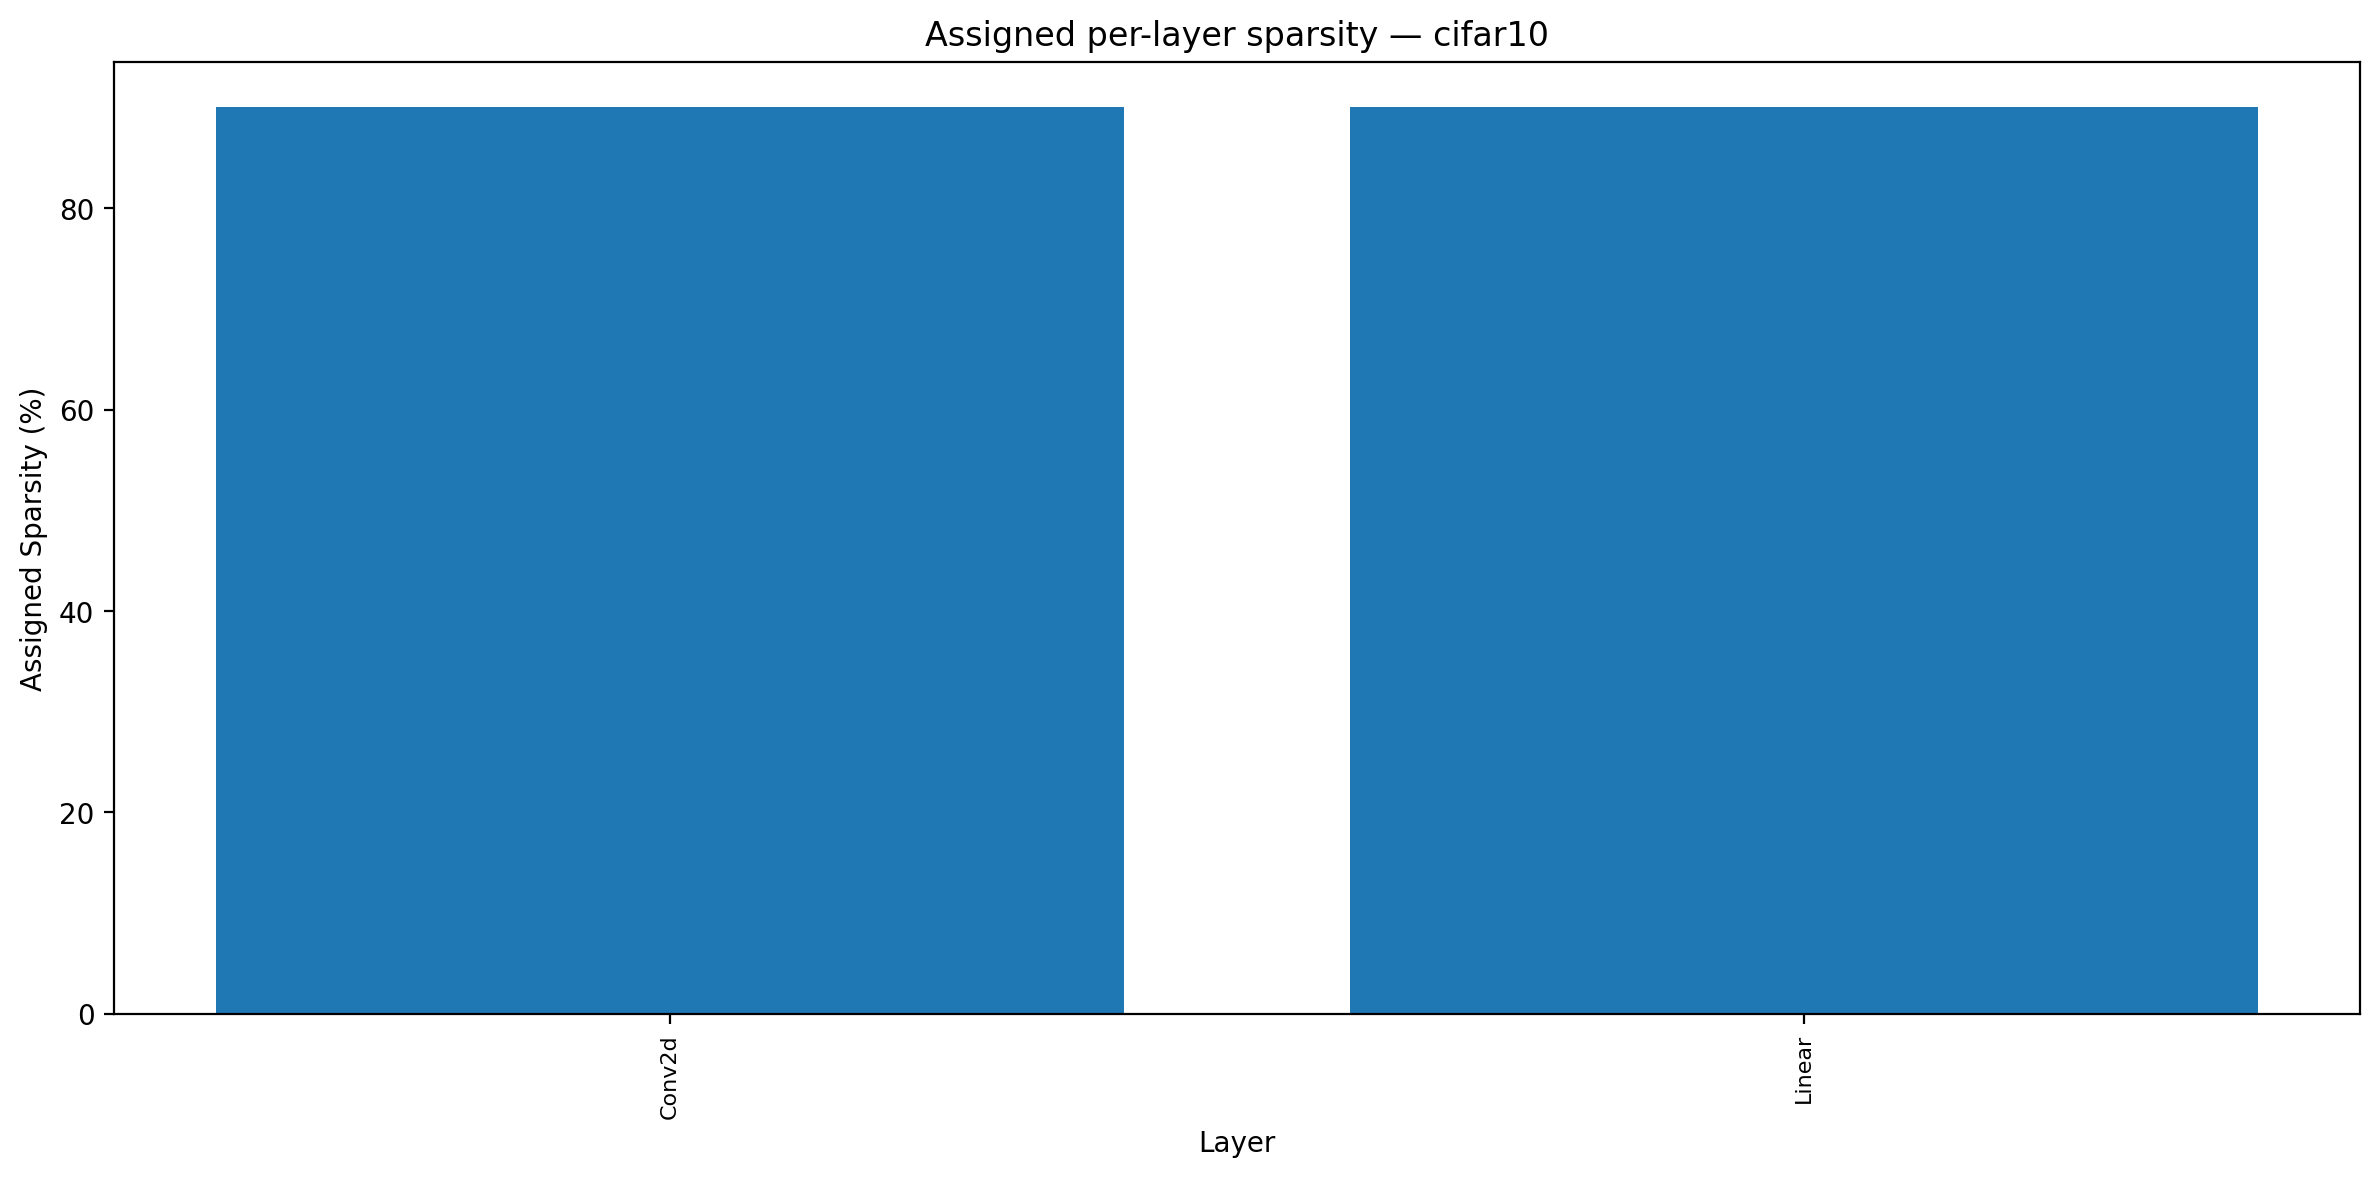

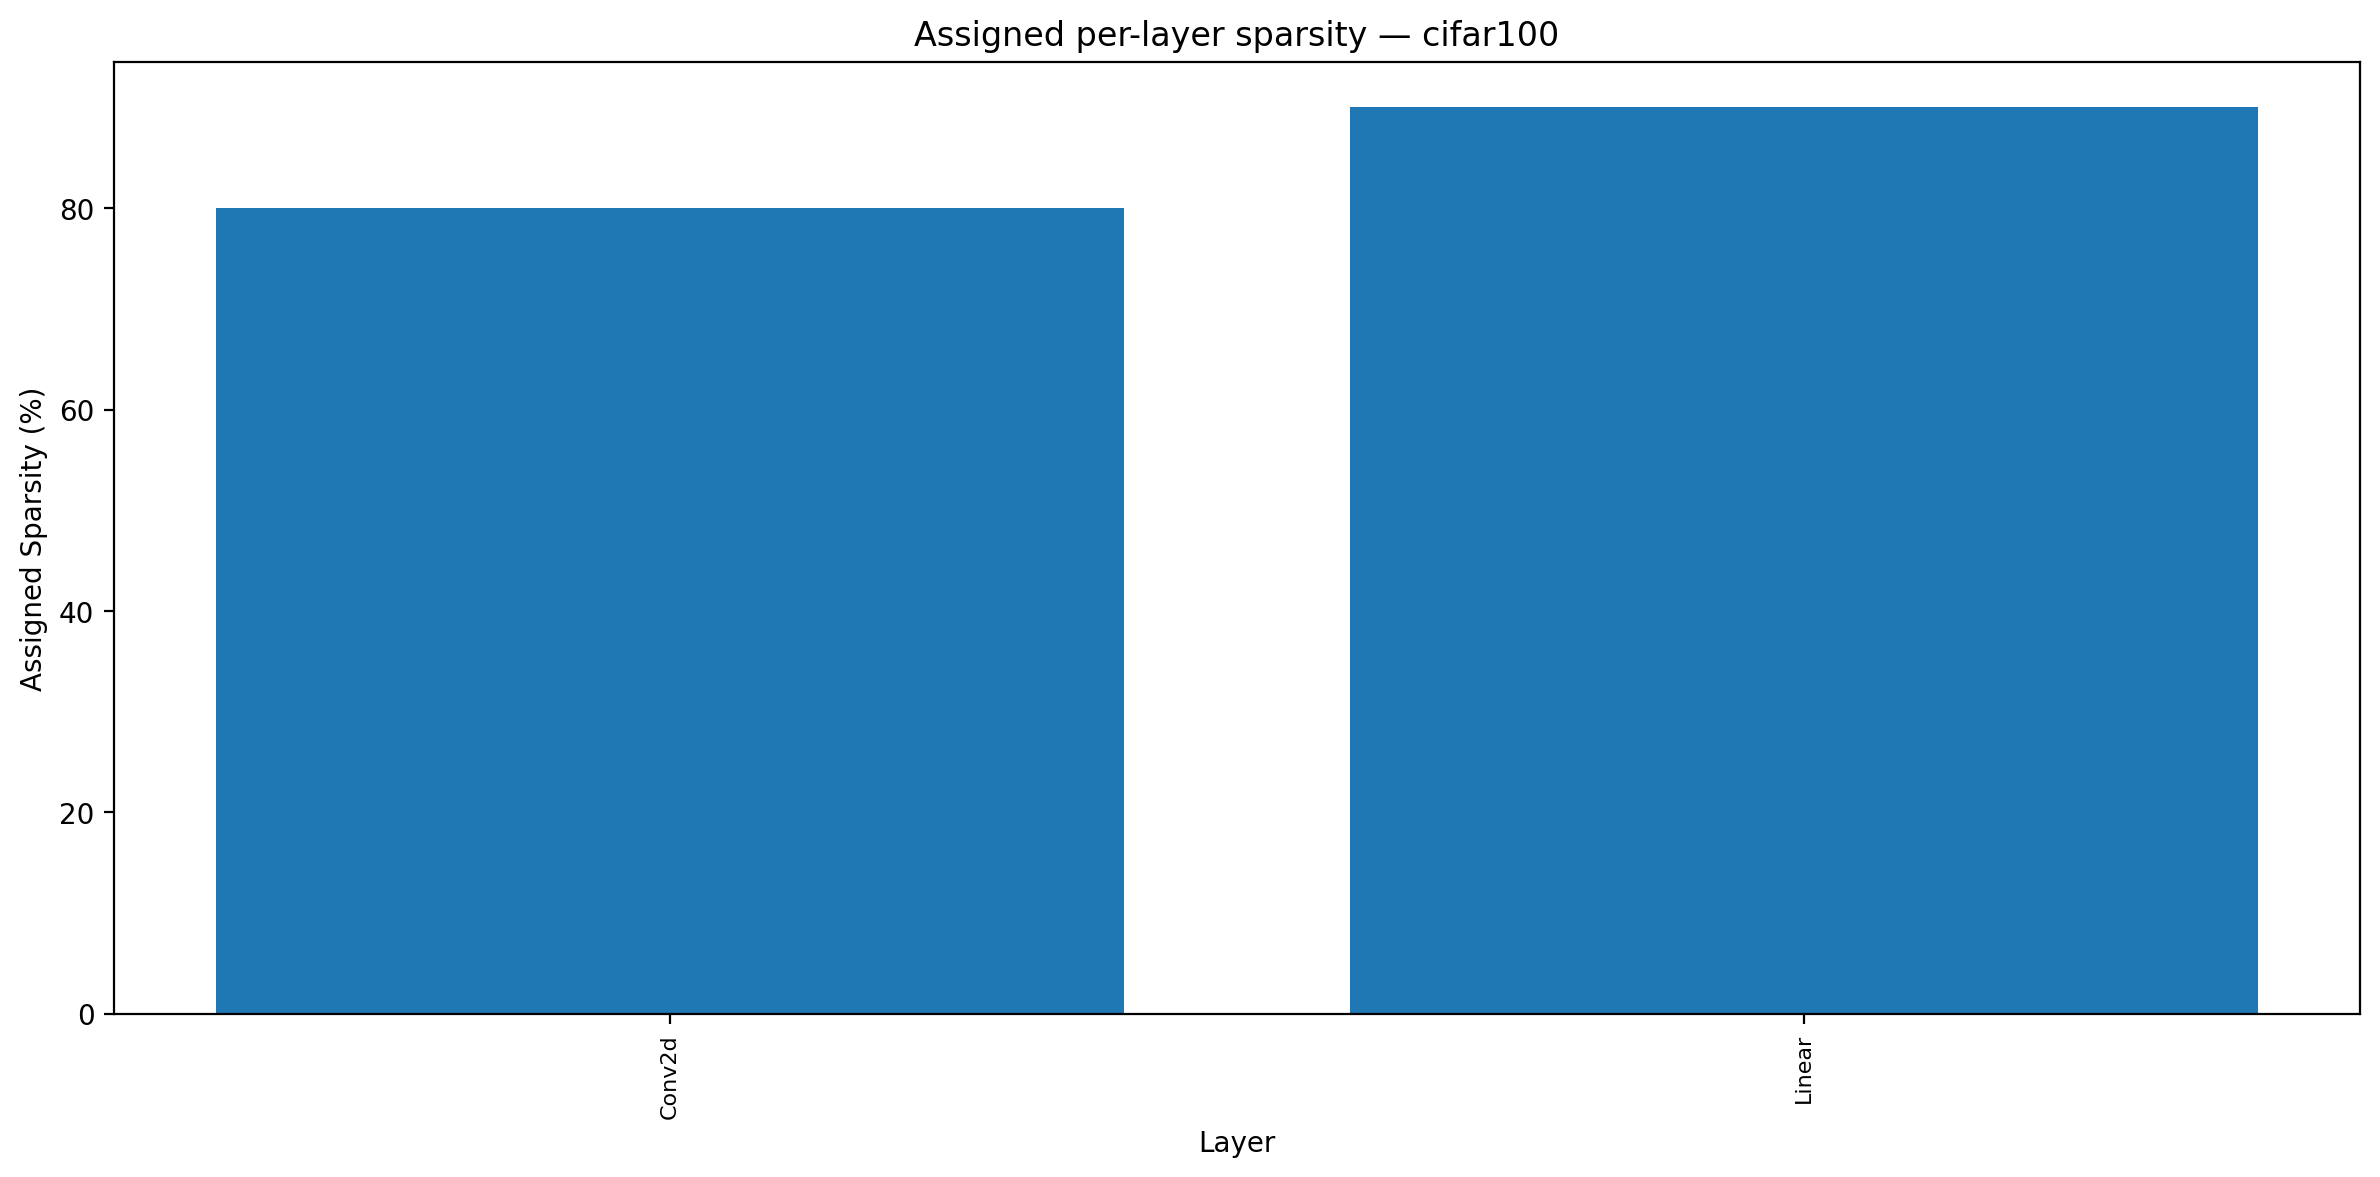

In [19]:
# Cell: Show sensitivity plot image files that were saved earlier (if you just want to display)
from IPython.display import Image, display
display(Image("plots/sensitivity_cifar10.png"))
display(Image("plots/sensitivity_cifar100.png"))
display(Image("plots/sparsity_plan_cifar10.png"))
display(Image("plots/sparsity_plan_cifar100.png"))
